# Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [3]:
data = pd.read_csv('tr_for_students.csv')

data.head()

,issue_d,purpose,addr_state,sub_grade,home_ownership,emp_title,installment,dti,funded_amnt,annual_inc,...,mths_since_recent_inq,delinq_2yrs,chargeoff_within_12_mths,num_accts_ever_120_pd,num_tl_90g_dpd_24m,acc_open_past_24mths,avg_cur_bal,tot_hi_cred_lim,delinq_amnt,def
0,2012-01-01,debt_consolidation,IL,C3,RENT,Chicago Shakespeare Theatre,172.48,16.39,5000,21600.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0
1,2013-01-01,debt_consolidation,FL,B4,MORTGAGE,Queen of Pawns,674.94,16.31,20000,95000.0,...,4.0,0,0,0.0,0.0,4.0,23735.0,153379.0,0,0
2,2013-07-01,debt_consolidation,NJ,B5,RENT,tek services,809.24,14.01,24000,90000.0,...,19.0,0,0,0.0,0.0,5.0,4070.0,50834.0,0,0
3,2014-03-01,debt_consolidation,MI,C2,MORTGAGE,Inventory Control,342.56,14.51,10000,43000.0,...,5.0,1,1,4.0,1.0,3.0,1127.0,32683.0,0,0
4,2013-10-01,credit_card,TX,D2,MORTGAGE,Business Analyst,473.58,22.65,13000,62000.0,...,5.0,0,0,0.0,0.0,5.0,3443.0,59495.0,0,0


In [4]:
data.columns

Index(['issue_d', 'purpose', 'addr_state', 'sub_grade', 'home_ownership',
       'emp_title', 'installment', 'dti', 'funded_amnt', 'annual_inc',
       'emp_length', 'term', 'inq_last_6mths', 'mths_since_recent_inq',
       'delinq_2yrs', 'chargeoff_within_12_mths', 'num_accts_ever_120_pd',
       'num_tl_90g_dpd_24m', 'acc_open_past_24mths', 'avg_cur_bal',
       'tot_hi_cred_lim', 'delinq_amnt', 'def'],
      dtype='object')

# Exploratory Data Analysis

Целевой переменной является переменная def, которая принимает два значения: 0, если клиент вернул кредит и 1, если клиент не смог вернуть кредит. Посмотрим на распределение значений целевой переменной.

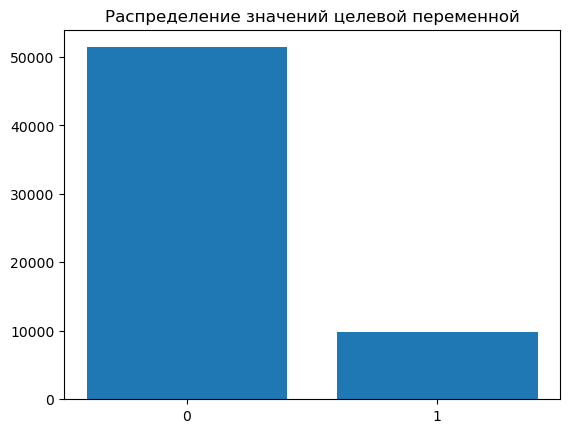

In [5]:
plt.bar(data['def'].value_counts().index, data['def'].value_counts())
plt.xticks([0, 1])
plt.title('Распределение значений целевой переменной');

Как мы можем увидеть, в имеющемся датасете примеров клиентов, вернувших кредит, значительно больше чем примеров тех, кто кредит не вернул.

Посмотрим на динамику распределения значений целевой переменной по годам.

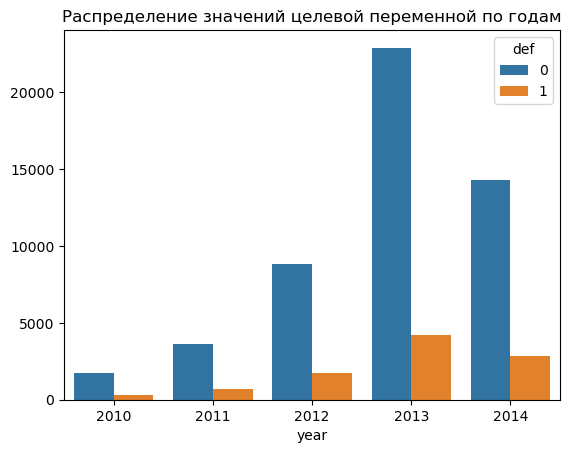

In [6]:
d = data[['issue_d', 'def', 'sub_grade']]
d['year'] = d['issue_d'].map(lambda x: int(x[:4]))
sns.barplot(data=d.groupby(['year', 'def']).agg({'sub_grade': 'count'}).reset_index(), x='year', y='sub_grade', hue='def')
plt.ylabel('')
plt.title('Распределение значений целевой переменной по годам');

Количество наблюдений по годам:

In [7]:
d['year'].value_counts()

2013    27082
2014    17103
2012    10615
2011     4321
2010     2048
Name: year, dtype: int64

В целом, пусть с течением времени число наблюдений для каждого года стремительно растет, каждый год представлен достаточно репрезентативно.

Теперь посмотрим на динамику распределения значений целевой переменной по месяцам.

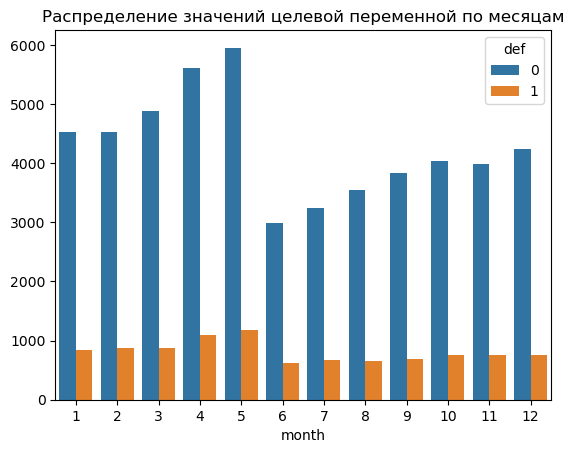

In [8]:
d['month'] = d['issue_d'].map(lambda x: int(x[5:7]))
sns.barplot(data=d.groupby(['month', 'def']).agg({'sub_grade': 'count'}).reset_index(), x='month', y='sub_grade', hue='def')
plt.ylabel('')
plt.title('Распределение значений целевой переменной по месяцам');

Количество наблюдений по месяцам:

In [9]:
d['month'].value_counts()

5     7137
4     6705
3     5766
2     5413
1     5367
12    5002
10    4782
11    4735
9     4523
8     4199
7     3917
6     3623
Name: month, dtype: int64

Наблюдения по месяцам распределились достаточно равномерно.

Посмотрим на динамику дефолт рейта по годам и по месяцам

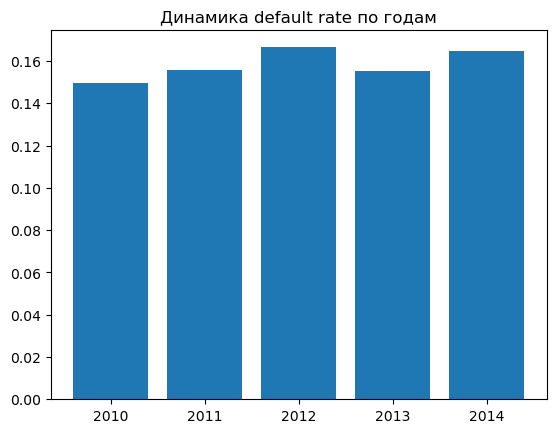

In [10]:
def_rate = d.groupby(['year']).agg({'def': 'sum', 'sub_grade': 'count'})
def_rate['def_rate'] = def_rate['def'] / def_rate['sub_grade']
plt.bar(data=def_rate.reset_index(), x='year', height='def_rate')
plt.title('Динамика default rate по годам');

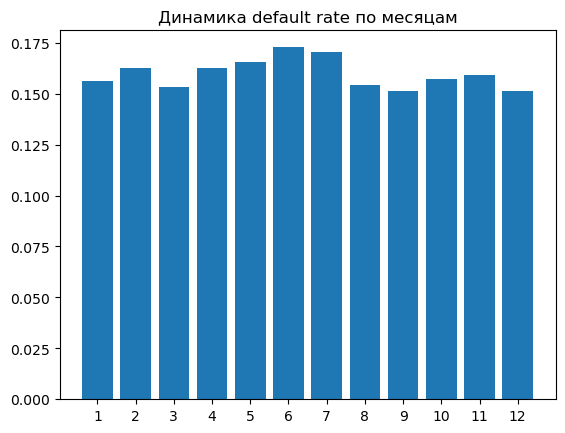

In [11]:
def_rate_m = d.groupby(['month']).agg({'def': 'sum', 'sub_grade': 'count'})
def_rate_m['def_rate'] = def_rate_m['def'] / def_rate_m['sub_grade']
plt.bar(data=def_rate_m.reset_index(), x='month', height='def_rate')
plt.xticks(np.arange(1, 13, 1))
plt.title('Динамика default rate по месяцам');

Как можно заметить, default rate от года к году и от месяца к месяцу особо не меняется.

Теперь посмотрим на признаки и корреляцию между ними.

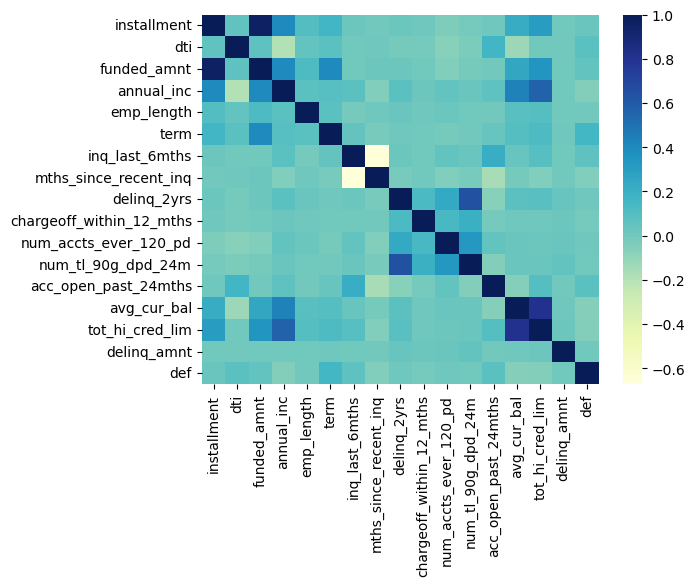

In [12]:
sns.heatmap(data.corr(), cmap="YlGnBu");

Так как чаще всего ставка кредита, которая входит в переменную installment, устанавливается исходя из PD, признак installment не должен быть известен на этапе скоринга, поэтому мы не будем использовать данный признак.

Сильно скоррелированными являются признаки inq_last_6mths и mths_since_recent_inq. Это объясняется тем, что inq_last_6mths -- количество обращений за займом в последние 6 месяцев, а mths_since_recent_inq - количество месяцев с последнего обращения. Соотвественно, при всех значениях mths_since_recent_inq > 6 значения признака inq_last_6mths будут равны 0 и наоборот.

Также сильно скоррелированными признаками являются delinq_2yrs и num_tl_90g_dpd_24m. Посмотрим на их совместную диаграмму рассеивания.

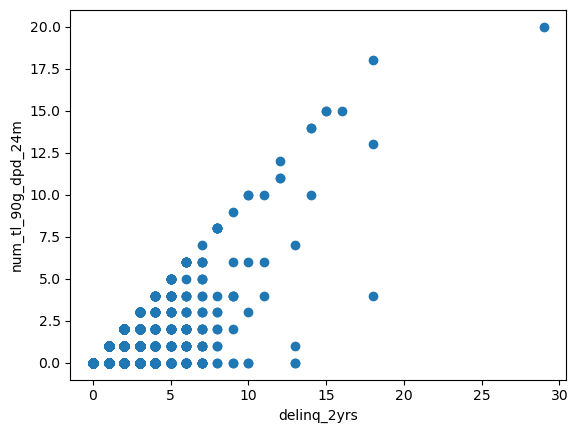

In [13]:
plt.scatter(data['delinq_2yrs'], data['num_tl_90g_dpd_24m'])
plt.xlabel('delinq_2yrs')
plt.ylabel('num_tl_90g_dpd_24m');

Данная зависимость объясняется тем, что delinq_2yrs -- количество случаев просрочки платежа более чем на 30 дней в кредитной истории заемщика за последние 2 года и num_tl_90g_dpd_24m -- количество счетов с просрочкой платежа на 90 или более дней за последние 24 месяца обозначают достаточно смежные вещи и для всех значений признака выполняется delinq_2yrs >= num_tl_90g_dpd_24m.

Еще одна скореллированная пара признаков - avg_cur_bal и tot_hi_cred_lim. Посмотрим на их совместную диаграмму рассеивания.

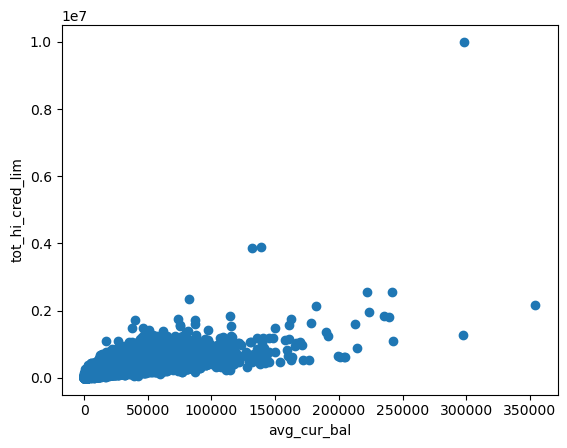

In [14]:
plt.scatter(data['avg_cur_bal'], data['tot_hi_cred_lim'])
plt.xlabel('avg_cur_bal')
plt.ylabel('tot_hi_cred_lim');

Наблюдаемая зависимость, довольно близкая к линейной, объясняется тем, что кредитный лимит для клиента устанавливается в том числе исходя из среднего текущего баланса на счетах клиента.

Ближе к концу, по итогам препроцессинга признаков, их WOE-преобразования и исключения неинформативных признаков, из каждой пары скореллированных признаков мы оставим более информативный в соответствии с IV.

Далее рассмотрим каждый из признаков по отдельности, в случае необходимости заполним пропуски, применим WOE-преобразование и отберем признаки для дальнейшей классификации из условия IV >= 0.02.

In [15]:
test = pd.DataFrame()
test['def'] = data['def']

# WOE-преобразование

In [16]:
def WOE(data, feature, target):
    woe_df = pd.DataFrame()
    s1 = data[target].sum()
    s0 = data[target].count() - s1
    woe_df['DistributionGood'] = data.groupby(feature).agg({target: 'sum'}) / s1
    woe_df['DistributionBad'] = (data.groupby(feature).agg({target: 'count'}) - data.groupby(feature).agg({target: 'sum'})) / s0
    woe_df = woe_df[woe_df['DistributionBad'] != 0]
    woe_df = woe_df[woe_df['DistributionGood'] != 0]
    woe_df['WOE'] = np.log(woe_df['DistributionGood'] / woe_df['DistributionBad'])
    woe_df['IV'] = (woe_df['DistributionGood'] - woe_df['DistributionBad']) * woe_df['WOE']
    return woe_df, woe_df['WOE'], woe_df['IV'].sum()

## issue_d

In [17]:
data['issue_d'].isna().sum()

0

In [18]:
data['issue_d'].unique()

array(['2012-01-01', '2013-01-01', '2013-07-01', '2014-03-01',
       '2013-10-01', '2011-11-01', '2011-04-01', '2014-05-01',
       '2014-02-01', '2013-08-01', '2013-04-01', '2012-11-01',
       '2010-11-01', '2012-03-01', '2012-07-01', '2013-09-01',
       '2014-04-01', '2013-03-01', '2014-01-01', '2013-05-01',
       '2012-12-01', '2013-06-01', '2012-04-01', '2013-11-01',
       '2012-08-01', '2012-05-01', '2013-12-01', '2011-03-01',
       '2013-02-01', '2010-08-01', '2011-10-01', '2011-07-01',
       '2011-08-01', '2010-06-01', '2012-10-01', '2012-09-01',
       '2010-09-01', '2011-01-01', '2010-10-01', '2011-05-01',
       '2012-06-01', '2011-06-01', '2011-12-01', '2012-02-01',
       '2010-05-01', '2011-09-01', '2010-07-01', '2010-04-01',
       '2011-02-01', '2010-12-01'], dtype=object)

Так как модель строится для предсказаний, год из обучающей выборки стоит убрать, так как в будущем регулярно будут возникать значения года, не встречавшиеся ранее.

Также дата выдачи кредита уже приведена к месяцу, поэтому оставим только номер месяца.

In [19]:
test['issue_d'] = data['issue_d'].astype('datetime64[ns]').map(lambda x: x.month)

In [20]:
test['issue_d'].value_counts()

5     7137
4     6705
3     5766
2     5413
1     5367
12    5002
10    4782
11    4735
9     4523
8     4199
7     3917
6     3623
Name: issue_d, dtype: int64

Применим WOE-преобразование к месяцу выдачи кредита

In [21]:
res, woe, iv = WOE(test, 'issue_d', 'def')
res

,DistributionGood,DistributionBad,WOE,IV
issue_d,,,,
1,0.085843,0.088101,-0.025961,0.000059
2,0.090248,0.088159,0.023416,0.000049
3,0.090453,0.094987,-0.048913,0.000222
4,0.111760,0.109207,0.023108,0.000059
5,0.121184,0.115821,0.045267,0.000243
6,0.064126,0.058299,0.095260,0.000555
7,0.068326,0.063221,0.077657,0.000396
8,0.066277,0.069096,-0.041643,0.000117
9,0.070068,0.074679,-0.063732,0.000294


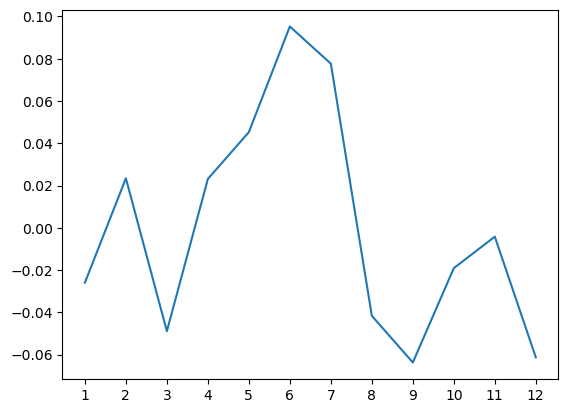

In [22]:
r = res.sort_values(by='issue_d')
x = list(r.index)
y = r['WOE']
plt.plot(x, y)
plt.xticks(x);

Как можно увидеть, никакой монотонности значений WOE в зависимости от месяца не наблюдается

In [23]:
iv

0.0023244007298425843

IV также заметно ниже порогового значения 0.02

Попробуем сгруппировать по кварталам:

In [24]:
test['issue_date_quarter'] = test['issue_d'].map(lambda x: (x - 1) // 3 + 1)

res, woe, iv = WOE(test, 'issue_date_quarter', 'def')
res

,DistributionGood,DistributionBad,WOE,IV
issue_date_quarter,,,,
1,0.266544,0.271247,-0.017492,0.000082
2,0.297070,0.283327,0.047366,0.000651
3,0.204671,0.206995,-0.011291,0.000026
4,0.231715,0.238431,-0.028571,0.000192


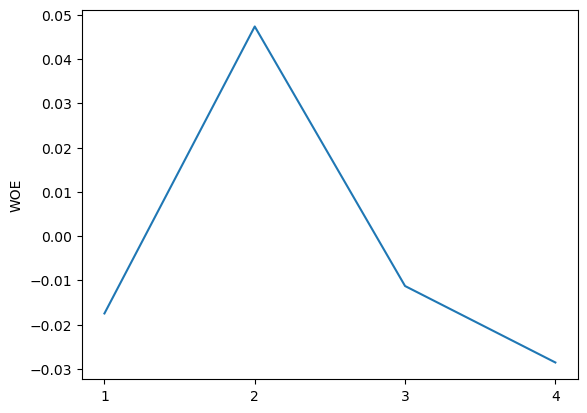

In [25]:
r = res.sort_values(by='issue_date_quarter')
x = list(r.index)
y = r['WOE']
plt.plot(x, y)
plt.xticks(x)
plt.ylabel('WOE');

In [26]:
iv

0.0009513454653790662

Для кварталов IV еще меньше. Никакой монотонности не появилось.

Выходит, что знание о месяце выдачи кредита ни при каком из вариантов группировки не является сильным признаком. Поэтому мы не будем использовать данный признак для дальнейшей классификации.

## purpose

In [27]:
data['purpose'].isna().sum()

0

In [28]:
data['purpose'].value_counts()

debt_consolidation    35587
credit_card           13722
home_improvement       3549
other                  3111
major_purchase         1378
small_business          969
car                     758
medical                 587
moving                  400
wedding                 390
house                   356
vacation                306
renewable_energy         43
educational              13
Name: purpose, dtype: int64

Есть две категории, встречающиеся очень редко: "educational" и "renewable_energy", и отдельная категория "other", включающая в себя редкие категории. Отнесем "educational" и "renewable_energy" к "other".

In [29]:
test['purpose'] = data['purpose'].map(lambda x: 'other' if x in ['educational', 'renewable_energy'] else x)

Применим WOE-преобразование:

In [30]:
res, woe, iv = WOE(test, 'purpose', 'def')
res

,DistributionGood,DistributionBad,WOE,IV
purpose,,,,
car,0.007785,0.013267,-0.533019,2.921684e-03
credit_card,0.188179,0.231194,-0.205866,8.855448e-03
debt_consolidation,0.616267,0.575233,0.068905,2.827482e-03
home_improvement,0.050707,0.059408,-0.158373,1.378069e-03
house,0.005839,0.005816,0.003885,8.794643e-08
major_purchase,0.018951,0.023207,-0.202594,8.622222e-04
medical,0.010961,0.009337,0.160320,2.602982e-04
moving,0.007580,0.006342,0.178445,2.210690e-04
other,0.057980,0.050596,0.136220,1.005807e-03


In [31]:
print(f'Получившийся IV: {iv}')

Получившийся IV: 0.02912567547478906


Так как IV >= 0.02, будет иметь смысл включить данный признак в дальнейшую классификацию.

In [32]:
woe_purpose = dict(woe)
def purpose_processing(df):
    values = list(df.unique())
    return df.map(lambda x: 'other' if x in ['educational', 'renewable_energy'] or x not in values else x).map(woe_purpose)

In [33]:
data_processing = {}
data_processing['purpose'] = purpose_processing

## addr_state

In [34]:
data['addr_state'].isna().sum()

0

In [35]:
data['addr_state'].unique()

array(['IL', 'FL', 'NJ', 'MI', 'TX', 'NY', 'CA', 'CO', 'MD', 'LA', 'PA',
       'TN', 'OH', 'DC', 'SC', 'NC', 'VA', 'NV', 'WA', 'MA', 'UT', 'AZ',
       'KY', 'AL', 'IN', 'MO', 'CT', 'GA', 'OR', 'OK', 'MT', 'RI', 'NM',
       'NH', 'MN', 'DE', 'WI', 'KS', 'WV', 'VT', 'AR', 'SD', 'HI', 'AK',
       'WY', 'MS', 'IA'], dtype=object)

In [36]:
test['addr_state'] = data['addr_state']

Применим WOE-преобразование:

In [37]:
res, woe, iv = WOE(test, 'addr_state', 'def')
iv

0.017777314918203328

IV меньше порогового значения, попробуем сгруппировать штаты по субрегионам:

In [38]:
us_subregions = {'WA': 'Pacific', 'OR': 'Pacific', 'CA': 'Pacific', 'AK': 'Pacific', 'HI': 'Pacific', 
 'MT': 'Mountain', 'ID': 'Mountain', 'WY': 'Mountain', 'NV': 'Mountain', 'UT': 'Mountain', 'CO': 'Mountain', 'AZ': 'Mountain', 'NM': 'Mountain',
 'ND': 'West North Central', 'MN': 'West North Central', 'SD': 'West North Central', 'IA': 'West North Central', 'NE': 'West North Central', 'KS': 'West North Central', 'MO': 'West North Central', 
 'WI': 'East North Central', 'MI': 'East North Central', 'IL': 'East North Central', 'IN': 'East North Central', 'OH': 'East North Central', 
 'PA': 'Middle Atantic', 'NY': 'Middle Atantic', 'NJ': 'Middle Atantic',
 'VT': 'New England', 'NH': 'New England', 'ME': 'New England', 'MA': 'New England', 'CT': 'New England', 'RI': 'New England', 
 'WV': 'South Atantic', 'MD': 'South Atantic', 'DE': 'South Atantic', 'DC': 'South Atantic', 'VA': 'South Atantic', 'NC': 'South Atantic', 'SC': 'South Atantic', 'GA': 'South Atantic', 'FL': 'South Atantic', 
 'KY': 'East South Central', 'TN': 'East South Central', 'MS': 'East South Central', 'AL': 'East South Central', 
 'OK': 'West South Central', 'AR': 'West South Central', 'TX': 'West South Central', 'LA': 'West South Central'
}

In [39]:
test['addr_state_subr'] = data['addr_state'].map(us_subregions)

In [40]:
res, woe, iv = WOE(test, 'addr_state_subr', 'def')
res

,DistributionGood,DistributionBad,WOE,IV
addr_state_subr,,,,
East North Central,0.124052,0.120528,0.028820,0.000102
East South Central,0.038517,0.033147,0.150132,0.000806
Middle Atantic,0.169740,0.155135,0.089974,0.001314
Mountain,0.068633,0.078569,-0.135198,0.001343
New England,0.046507,0.050888,-0.090027,0.000394
Pacific,0.194325,0.205809,-0.057415,0.000659
South Atantic,0.217578,0.204486,0.062061,0.000813
West North Central,0.046302,0.046706,-0.008681,0.000004
West South Central,0.094345,0.104733,-0.104450,0.001085


In [41]:
iv

0.00651981454516252

Получившийся IV слишком мал, так что в дальнейшую классификацию данный признак не пойдет

## sub_grade

In [42]:
data['sub_grade'].isna().sum()

0

In [43]:
data['sub_grade'].value_counts()

B3    4714
B4    4292
B2    3731
C1    3562
C2    3447
B5    3239
B1    3205
C3    3189
C4    3146
C5    2899
A5    2866
A4    2536
D1    2417
D2    2115
D3    1869
D4    1682
A3    1658
D5    1433
A2    1376
A1    1310
E1    1050
E2    1043
E3     847
E4     755
E5     641
F1     503
F2     415
F3     380
F4     232
F5     217
G1     129
G2     112
G3      75
G4      47
G5      37
Name: sub_grade, dtype: int64

Так как присутствуют значения признака с малым количеством наблюдений, сгруппируем значения по первой букве.

In [44]:
test['sub_grade'] = data['sub_grade'].map(lambda x: x[0])

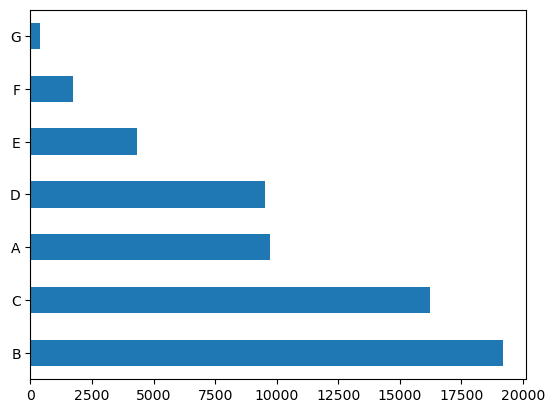

In [45]:
test['sub_grade'].value_counts().plot(kind='barh');

Применим WOE-преобразование:

In [46]:
res, woe, iv = WOE(test, 'sub_grade', 'def')
res

,DistributionGood,DistributionBad,WOE,IV
sub_grade,,,,
A,0.057058,0.178750,-1.141920,0.138963
B,0.213276,0.332620,-0.444414,0.053038
C,0.298504,0.259284,0.140862,0.005525
D,0.224134,0.142549,0.452562,0.036923
E,0.129891,0.059681,0.777692,0.054602
F,0.060848,0.022429,0.998034,0.038344
G,0.016288,0.004688,1.245384,0.014446


Нарисуем график зависимости WOE от признака (здесь вполне можно упорядочить значения признака)

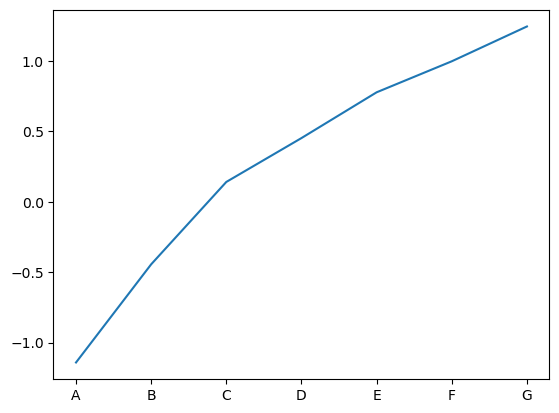

In [47]:
r = res.sort_values(by='sub_grade')
x = list(r.index)
y = r['WOE']
plt.plot(x, y)
plt.xticks(x);

In [48]:
iv

0.3418401462605079

Зависимость WOE от значений признака получается очень монотонной и IV признака больше порогового значения, так что берем его в классификацию.

In [49]:
woe_sub_grade = dict(woe)

def sub_grade_processing(df):
    return df.map(lambda x: x[0]).map(woe_sub_grade)

In [50]:
data_processing['sub_grade'] = sub_grade_processing

## home_ownership

In [51]:
data['home_ownership'].isna().sum()

0

In [52]:
data['home_ownership'].value_counts()

MORTGAGE    31414
RENT        24581
OWN          5158
OTHER          10
NONE            6
Name: home_ownership, dtype: int64

Отнесем значение признака NONE к значению OTHER

In [53]:
test['home_ownership'] = data['home_ownership'].map(lambda x: 'OTHER' if x == 'NONE' else x)

Применим WOE:

In [54]:
res, woe, iv = WOE(test, 'home_ownership', 'def')
res

,DistributionGood,DistributionBad,WOE,IV
home_ownership,,,,
MORTGAGE,0.466913,0.522419,-0.112328,0.006235
OTHER,0.000307,0.000253,0.194940,0.000011
OWN,0.086355,0.083938,0.028391,0.000069
RENT,0.446425,0.393390,0.126470,0.006707


In [55]:
print(f'Получившийся IV: {iv}')

Получившийся IV: 0.013021511755184345


IV меньше порогового значения, в связи с чем не берем признак в дальнейшую классификацию

## emp_title

In [56]:
data['emp_title'].isna().sum()

3865

In [57]:
data['emp_title'].value_counts(dropna=False)

NaN                           3865
Teacher                        505
Manager                        420
Registered Nurse               239
RN                             237
                              ... 
Chesapeake energy                1
Commercial Banking Officer       1
US Navy (Civil Service)          1
Gemini Sales & Services          1
receptionoist                    1
Name: emp_title, Length: 38577, dtype: int64

38+ тысяч различных значений признака - не есть хорошо. Попробуем выделить конкретные названия профессий из данных значений.

In [58]:
def profession(desc, top_prof):
    words = str(desc).split()
    for w in words:
        if w.lower()[-2:] in ('er', 'or', 'ee') or w.lower()[-3:] in ('ant', 'ian', 'ist', 'ent') or w.lower() in top_prof:
            return w.lower()
    if str(desc).lower() in top_prof:
        return str(desc).lower()
    return 'other'

In [59]:
top_prof = list(data['emp_title'].map(lambda x: str(x).lower()).value_counts(dropna=False)[:50].index)

test['emp_title'] = data['emp_title'].map(lambda x: profession(x, top_prof))
test['emp_title'].value_counts()

other            31231
nan               3867
manager           3237
director           908
sales              878
                 ...  
larimer              1
mechinist            1
tenant               1
hollyfrontier        1
receptionoist        1
Name: emp_title, Length: 1952, dtype: int64

При помощи данной обработки удалось сократить количество различных значений в 20 раз. Осталось убрать особенно редкие категории.

In [60]:
top_prof = list(test['emp_title'].value_counts(dropna=False)[:60].index)

test['emp_title'] = test['emp_title'].map(lambda x: x if x in top_prof else 'other')
test['emp_title'].value_counts()[:20]

other          38536
nan             3867
manager         3237
director         908
sales            878
center           843
assistant        822
teacher          718
senior           715
supervisor       652
nurse            600
analyst          587
engineer         586
specialist       570
officer          544
driver           536
department       510
technician       460
rn               323
coordinator      320
Name: emp_title, dtype: int64

Применим WOE:

In [61]:
res, woe, iv = WOE(test, 'emp_title', 'def')
iv

0.02119904036250188

IV >= 0.02, поэтому берем признак в дальнейшую классификацию

In [62]:
top_prof = list(test['emp_title'].value_counts(dropna=False)[:40].index)
woe_emp_title = dict(woe)

def emp_title_processing(df):
    return df.map(lambda x: profession(x, top_prof)).map(lambda x: x if x in top_prof else 'other').map(woe_emp_title)

In [63]:
data_processing['emp_title'] = emp_title_processing

## dti

In [64]:
data['dti'].isna().sum()

0

In [65]:
data['dti'].describe()

count    61169.000000
mean        16.782808
std          7.531950
min          0.000000
25%         11.180000
50%         16.500000
75%         22.200000
max         34.990000
Name: dti, dtype: float64

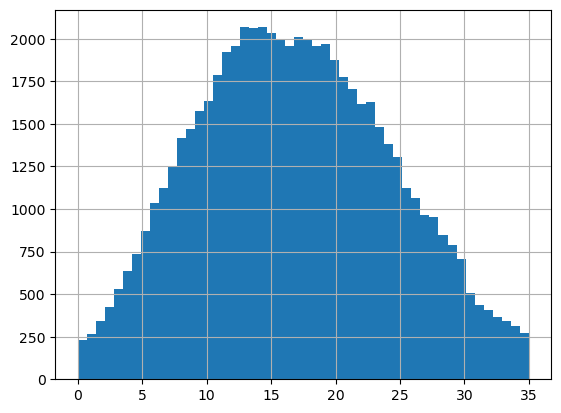

In [66]:
data['dti'].hist(bins=50);

Напишем алгоритм, группирующий наблюдения таким образом, чтобы в каждый из бакетов попадал хотя бы 1% наблюдений, бакетов было минимум 4 и максимум 22 и IV >= 0.02.

In [67]:
def bucketing(data, feature, min_size, max_size, step):
    t = pd.DataFrame()
    t['def'] = data['def']
    buckets_pre = []
    buckets = []
    bucket_size_iv = {}
    for i in tqdm(range(min_size, max_size + step, step)):
        if int(data[feature].max()) // i < 3:
            continue
        s = data[feature].map(lambda x: int(x) // i)
        d1 = {}
        for j in list(s.unique()):
            d1[j] = j
        for j in range(int(data[feature].max()) // i + 1):
            if j in list(s.unique()):
                k = 0
                while s.value_counts(normalize=True).loc[j] < 0.01:
                    k += 1
                    if j + k > int(data[feature].max()) // i:
                        break
                    if j + k not in list(s.unique()):
                        continue
                    s = s.map(lambda x: j if x == j + k else x)
                    d1[j + k] = j
        for j in range(int(data[feature].max()) // i + 1, -1, -1):
            if j in list(s.unique()) and j >= 1:
                if s.value_counts(normalize=True).loc[j] < 0.01:
                    s = s.map(lambda x: j - 1 if x == j else x)
                    d1[j] = j - 1
        for _ in range(10):
            for el in d1:
                to = d1[d1[el]]
                d1[el] = to
        t[feature] = s
        res, woe, iv = WOE(t, feature, 'def')
        if s.value_counts(normalize=True).min() >= 0.01 and iv >= 0.02 and len(set(d1.values())) >= 4 and len(set(d1.values())) <= 23:
            if len(set(d1.values())) not in bucket_size_iv:
                bucket_size_iv[len(set(d1.values()))] = iv
                buckets_pre.append((i, d1, iv))
            elif iv > bucket_size_iv[len(set(d1.values()))]:
                bucket_size_iv[len(set(d1.values()))] = iv
                buckets_pre.append((i, d1, iv))
    for b in buckets_pre:
        if bucket_size_iv[len(set(b[1].values()))] == b[2]:
            buckets.append(b)
    return buckets

In [68]:
buckets = bucketing(data, 'dti', 1, 35, 1)

  0%|          | 0/35 [00:00<?, ?it/s]

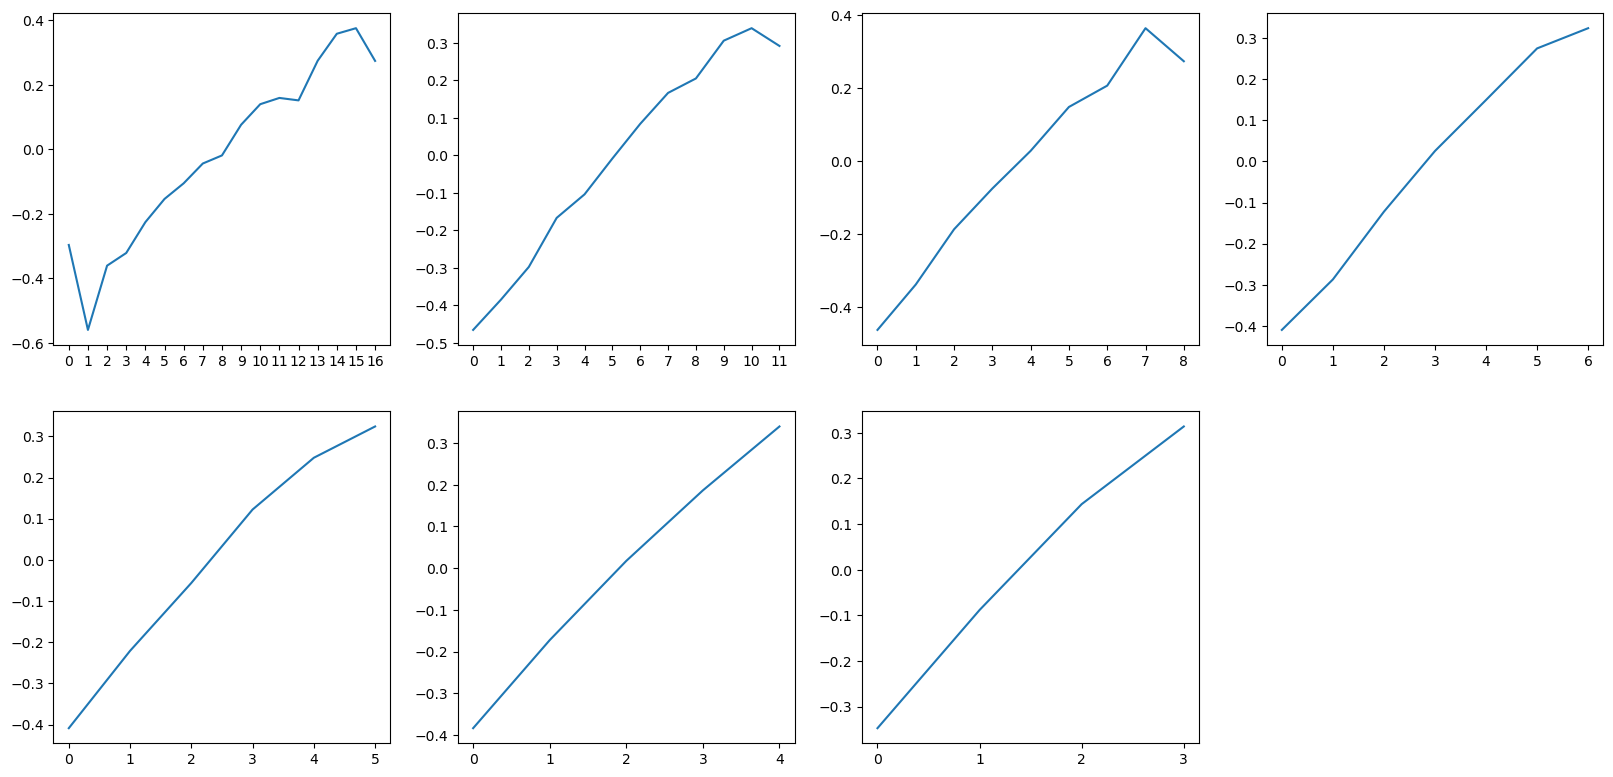

In [69]:
i = 0
fig = plt.figure(figsize=(20, 25))
for b in buckets:
    size = b[0]
    d = b[1]
    i += 1
    plt.subplot(5, 4, i)
    test['dti'] = data['dti'].map(lambda x: int(x) // size).map(d)
    res, woe, iv = WOE(test, 'dti', 'def')
    r = res.sort_values(by='dti')
    x = list(r.index)
    y = r['WOE']
    plt.plot(x, y)
    plt.xticks(x);

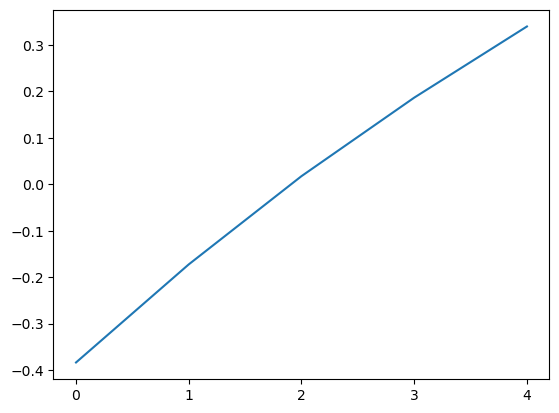

In [70]:
size_dti = buckets[5][0]
d_dti = buckets[5][1]

test['dti'] = data['dti'].map(lambda x: int(x) // size_dti).map(d_dti)
res, woe, iv = WOE(test, 'dti', 'def')
r = res.sort_values(by='dti')
x = list(r.index)
y = r['WOE']
plt.plot(x, y)
plt.xticks(x);

In [71]:
def final_buckets(bucket, df):
    ans = []
    for v in list(set(bucket[1].values())):
        ans.append(v * bucket[0])
    ans.append(df.max())
    ans = sorted(ans)
    f = []
    for i in range(len(ans) - 1):
        f.append(f'{ans[i]}-{ans[i + 1]}')
    print(*f, sep=', ')

In [72]:
final_buckets(buckets[5], data['dti'])

0-7, 7-14, 14-21, 21-28, 28-34.99


In [73]:
iv

0.0395097753690817

IV >= 0.02, поэтому берем данный признак в классификацию

In [74]:
woe_dti = dict(woe)

def closest(number, values):
    values_sort = sorted(values)
    if number in values:
        return number
    for i in range(len(values) - 1):
        if values_sort[i] <= number and values_sort[i + 1] > number:
            return values_sort[i]

def dti_processing(df):
    max_value = data['dti'].max()
    values = list(data['dti'].map(lambda x: min(int(x), max_value) // size_dti).unique())
    return df.map(lambda x: closest(min(int(x), max_value) // size_dti, values)).map(d_dti).map(woe_dti)

In [75]:
data_processing['dti'] = dti_processing

## funded_amnt

In [76]:
data['funded_amnt'].isna().sum()

0

In [77]:
data['funded_amnt'].describe()

count    61169.000000
mean     14159.664618
std       8181.125909
min       1000.000000
25%       8000.000000
50%      12000.000000
75%      20000.000000
max      35000.000000
Name: funded_amnt, dtype: float64

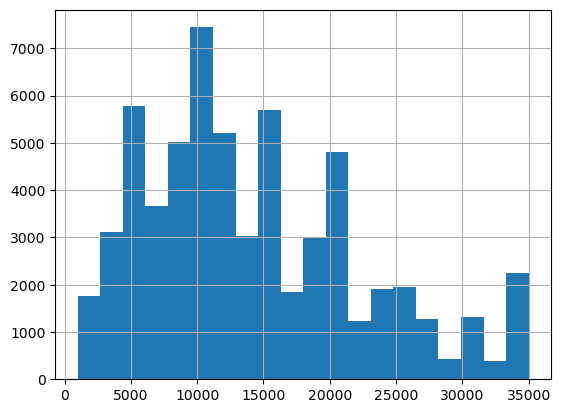

In [78]:
data['funded_amnt'].hist(bins=20);

In [79]:
buckets = bucketing(data, 'funded_amnt', 1000, 35000, 100)

  0%|          | 0/341 [00:00<?, ?it/s]

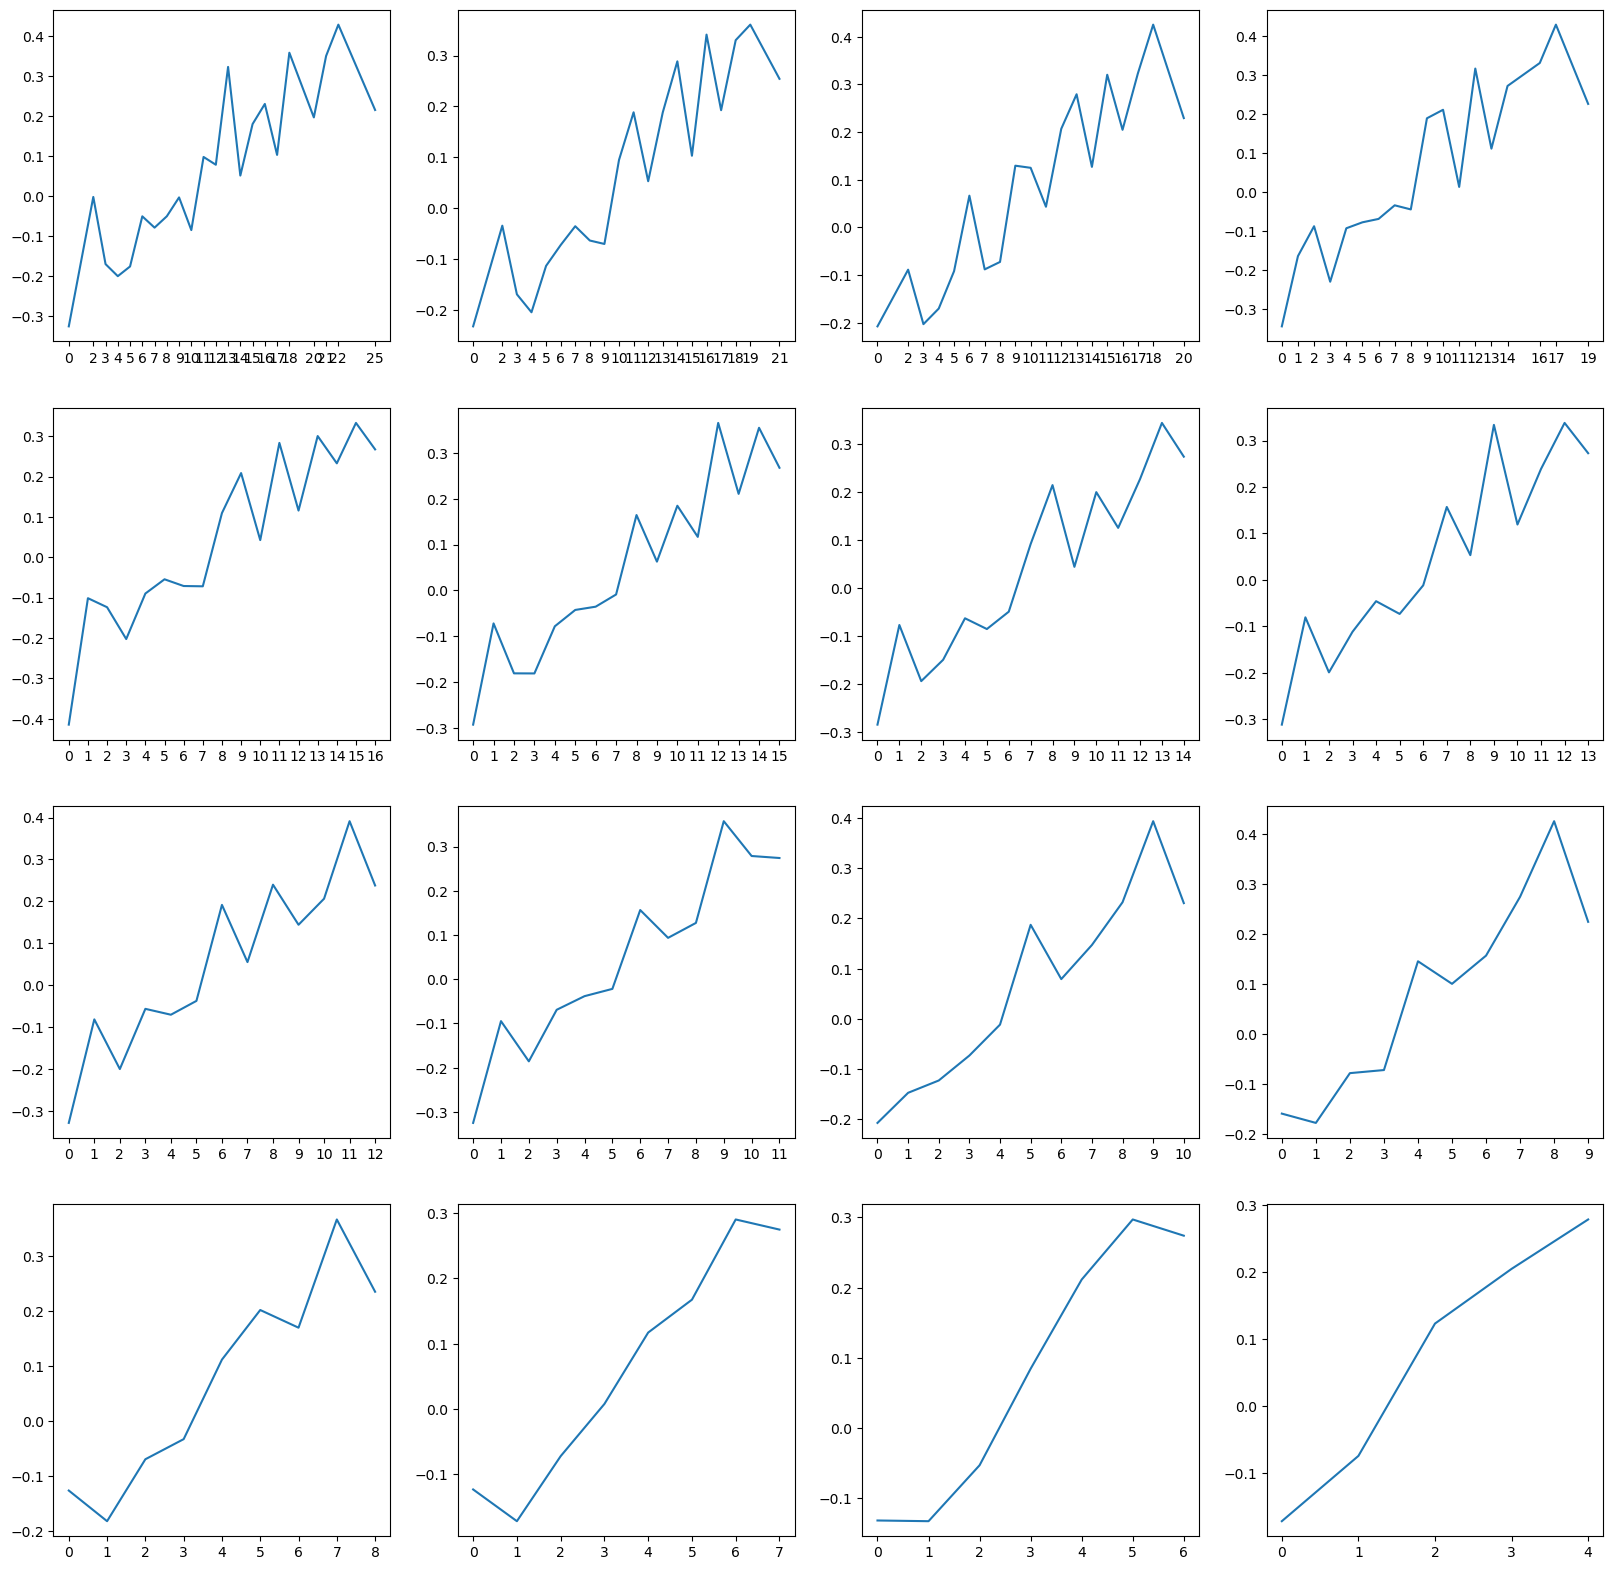

In [80]:
i = 0
fig = plt.figure(figsize=(20, 25))
for b in buckets:
    size = b[0]
    d = b[1]
    i += 1
    plt.subplot(5, 4, i)
    test['funded_amnt'] = data['funded_amnt'].map(lambda x: int(x) // size).map(d)
    res, woe, iv = WOE(test, 'funded_amnt', 'def')
    r = res.sort_values(by='funded_amnt')
    x = list(r.index)
    y = r['WOE']
    plt.plot(x, y)
    plt.xticks(x);

Выбираем график с самой близкой к монотонной зависимостью

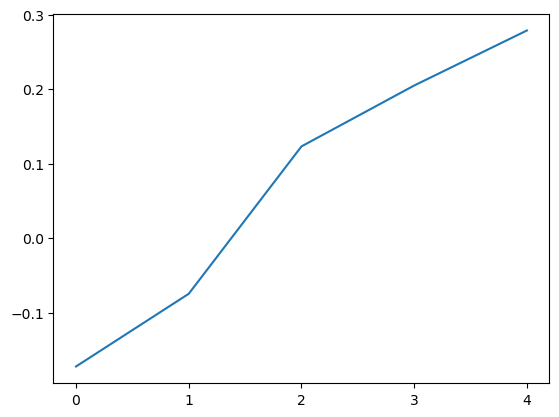

In [81]:
size_funded_amnt = buckets[-1][0]
d_funded_amnt = buckets[-1][1]

test['funded_amnt'] = data['funded_amnt'].map(lambda x: int(x) // size_funded_amnt).map(d_funded_amnt)
res, woe, iv = WOE(test, 'funded_amnt', 'def')
r = res.sort_values(by='funded_amnt')
x = list(r.index)
y = r['WOE']
plt.plot(x, y)
plt.xticks(x);

In [82]:
final_buckets(buckets[-1], data['funded_amnt'])

0-7600, 7600-15200, 15200-22800, 22800-30400, 30400-35000


In [83]:
iv

0.021035486647727687

In [84]:
woe_funded_amnt = dict(woe)

def funded_amnt_processing(df):
    max_value = data['funded_amnt'].max()
    values = list(data['funded_amnt'].map(lambda x: min(int(x), max_value) // size_funded_amnt).unique())
    return df.map(lambda x: closest(min(int(x), max_value) // size_funded_amnt, values)).map(d_funded_amnt).map(woe_funded_amnt)

In [85]:
data_processing['funded_amnt'] = funded_amnt_processing

## annual_inc

In [86]:
data['annual_inc'].isna().sum()

0

In [87]:
data['annual_inc'].describe()

count    6.116900e+04
mean     7.271755e+04
std      4.954698e+04
min      6.695000e+03
25%      4.500000e+04
50%      6.250000e+04
75%      8.800000e+04
max      3.900000e+06
Name: annual_inc, dtype: float64

In [88]:
buckets = bucketing(data, 'annual_inc', 7000, 3900000, 5000)

  0%|          | 0/780 [00:00<?, ?it/s]

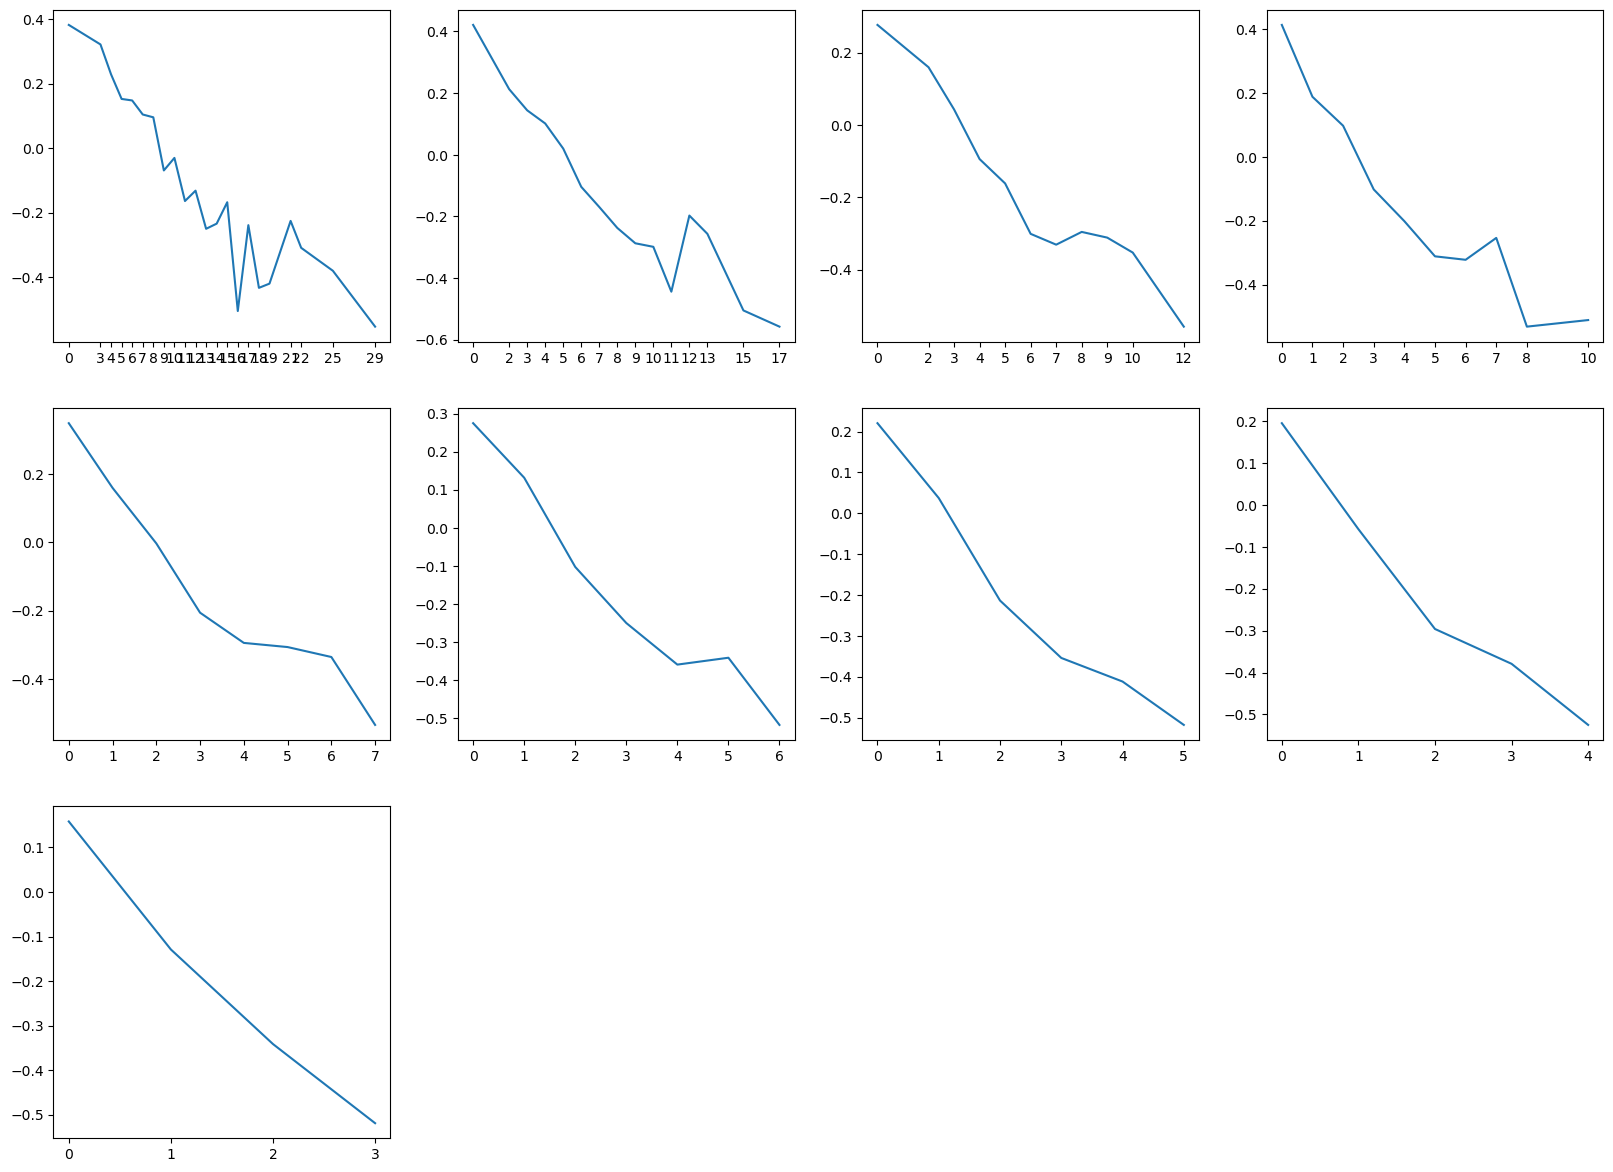

In [89]:
i = 0
fig = plt.figure(figsize=(20, 25))
for b in buckets:
    size = b[0]
    d = b[1]
    i += 1
    plt.subplot(5, 4, i)
    test['annual_inc'] = data['annual_inc'].map(lambda x: int(x) // size).map(d)
    res, woe, iv = WOE(test, 'annual_inc', 'def')
    r = res.sort_values(by='annual_inc')
    x = list(r.index)
    y = r['WOE']
    plt.plot(x, y)
    plt.xticks(x);

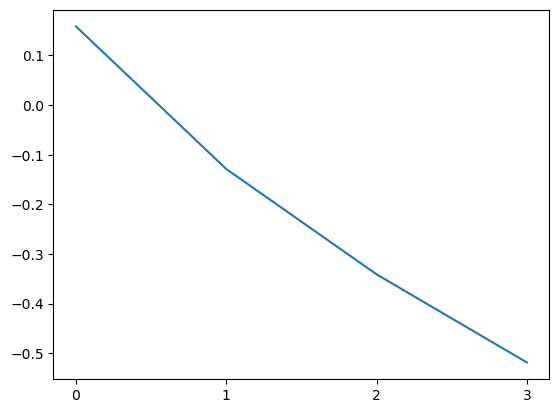

In [90]:
size_annual_inc = buckets[-1][0]
d_annual_inc = buckets[-1][1]

test['annual_inc'] = data['annual_inc'].map(lambda x: int(x) // size_annual_inc).map(d_annual_inc)
res, woe, iv = WOE(test, 'annual_inc', 'def')
r = res.sort_values(by='annual_inc')
x = list(r.index)
y = r['WOE']
plt.plot(x, y)
plt.xticks(x);

In [91]:
final_buckets(buckets[-1], data['annual_inc'])

0-62000, 62000-124000, 124000-186000, 186000-3900000.0


In [92]:
woe_annual_inc = dict(woe)

def annual_inc_processing(df):
    max_value = data['annual_inc'].max()
    values = list(data['annual_inc'].map(lambda x: min(int(x), max_value) // size_annual_inc).unique())
    return df.map(lambda x: closest(min(int(x), max_value) // size_annual_inc, values)).map(d_annual_inc).map(woe_annual_inc)

In [93]:
data_processing['annual_inc'] = annual_inc_processing

## emp_length

In [94]:
data['emp_length'].isna().sum()

2674

In [95]:
data['emp_length'].value_counts(dropna=False)

10.0    19715
2.0      5347
3.0      4775
0.0      4586
5.0      4342
1.0      3736
4.0      3665
6.0      3573
7.0      3558
8.0      2952
NaN      2674
9.0      2246
Name: emp_length, dtype: int64

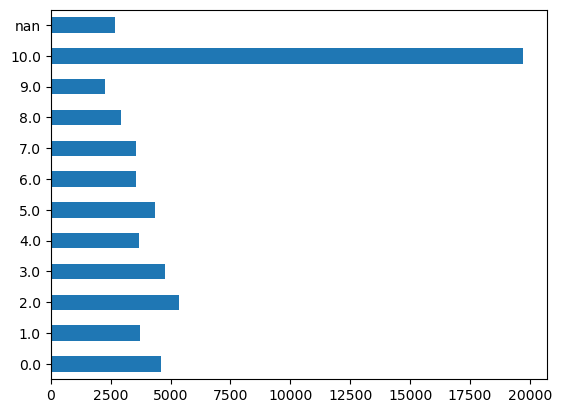

In [96]:
data['emp_length'].value_counts(dropna=False).sort_index().plot(kind='barh');

Попробуем поочередно заполнить пропуски нулем и медианой и посмотрим на получившиеся WOE

In [97]:
test['emp_length'] = data['emp_length'].fillna(0)
buckets = bucketing(test, 'emp_length', 1, 10, 1)
buckets

  0%|          | 0/10 [00:00<?, ?it/s]

[]

Для нуля вовсе не нашлось подходящих бакетов

In [98]:
test['emp_length'] = data['emp_length'].fillna(0)
res, woe, iv = WOE(test, 'emp_length', 'def')
iv

0.0033506646393428475

IV, как мы видим, тоже очень мал

In [99]:
med = data['emp_length'].median()
test['emp_length'] = data['emp_length'].fillna(med)
buckets = bucketing(test, 'emp_length', 1, 10, 1)
buckets

  0%|          | 0/10 [00:00<?, ?it/s]

[]

In [100]:
test['emp_length'] = data['emp_length'].fillna(med)
res, woe, iv = WOE(test, 'emp_length', 'def')
iv

0.0028995275673114997

Аналогичная ситуация для медианы

При любом из вариантов заполнения признак оказывается слишком слабым для предсказаний, поэтому мы не будем использовать его для дальнейшей классификации.

## term

In [101]:
data['term'].isna().sum()

0

In [102]:
data['term'].value_counts()

36    45173
60    15996
Name: term, dtype: int64

Применим WOE-преобразование

In [103]:
test['term'] = data['term']
res, woe, iv = WOE(test, 'term', 'def')
iv

0.15813470723119746

Признак оказался довольно сильным, поэтому оставляем его

In [104]:
woe_term = dict(woe)

def term_processing(df):
    return df.map(woe_term)

In [105]:
data_processing['term'] = term_processing

## inq_last_6mths

In [106]:
data['inq_last_6mths'].isna().sum()

0

In [107]:
data['inq_last_6mths'].value_counts()

0    30839
1    17097
2     8104
3     3670
4      961
5      335
6      137
7       17
8        9
Name: inq_last_6mths, dtype: int64

In [108]:
buckets = bucketing(data, 'inq_last_6mths', 1, 8, 1)

  0%|          | 0/8 [00:00<?, ?it/s]

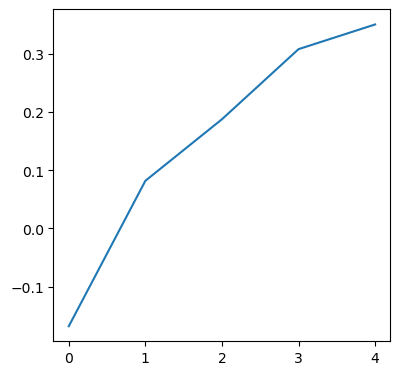

In [109]:
i = 0
fig = plt.figure(figsize=(20, 25))
for b in buckets:
    size = b[0]
    d = b[1]
    i += 1
    plt.subplot(5, 4, i)
    test['inq_last_6mths'] = data['inq_last_6mths'].map(lambda x: int(x) // size).map(d)
    res, woe, iv = WOE(test, 'inq_last_6mths', 'def')
    r = res.sort_values(by='inq_last_6mths')
    x = list(r.index)
    y = r['WOE']
    plt.plot(x, y)
    plt.xticks(x);

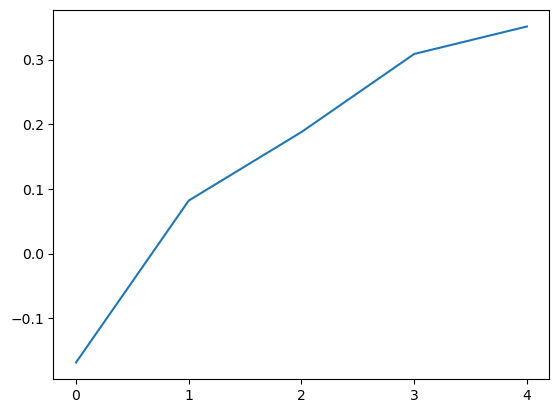

In [110]:
size_inq_last_6mths = buckets[0][0]
d_inq_last_6mths = buckets[0][1]

test['inq_last_6mths'] = data['inq_last_6mths'].map(lambda x: int(x) // size_inq_last_6mths).map(d_inq_last_6mths)
res, woe, iv = WOE(test, 'inq_last_6mths', 'def')
r = res.sort_values(by='inq_last_6mths')
x = list(r.index)
y = r['WOE']
plt.plot(x, y)
plt.xticks(x);

In [111]:
final_buckets(buckets[0], data['inq_last_6mths'])

0-1, 1-2, 2-3, 3-4, 4-8


In [112]:
woe_inq_last_6mths = dict(woe)

def inq_last_6mths_processing(df):
    max_value = data['inq_last_6mths'].max()
    values = list(data['inq_last_6mths'].map(lambda x: min(int(x), max_value) // size_inq_last_6mths).unique())
    return df.map(lambda x: closest(min(int(x), max_value) // size_inq_last_6mths, values)).map(d_inq_last_6mths).map(woe_inq_last_6mths)

In [113]:
data_processing['inq_last_6mths'] = inq_last_6mths_processing

## mths_since_recent_inq

In [114]:
data['mths_since_recent_inq'].isna().sum()

13529

In [115]:
data['mths_since_recent_inq'].value_counts(dropna=False)

NaN     13529
1.0      5106
0.0      4248
2.0      4023
3.0      3607
4.0      3430
5.0      3064
7.0      2860
6.0      2841
8.0      2574
9.0      2180
10.0     1959
11.0     1662
12.0     1542
13.0     1340
14.0     1206
15.0      986
16.0      869
17.0      751
18.0      671
19.0      634
20.0      558
21.0      474
22.0      426
23.0      416
24.0      213
Name: mths_since_recent_inq, dtype: int64

Поочередно заполним пропуски нулем и медианой и посмотрим на получившиеся WOE

In [116]:
test['mths_since_recent_inq'] = data['mths_since_recent_inq'].fillna(0)
buckets = bucketing(test, 'mths_since_recent_inq', 1, 24, 1)
buckets

  0%|          | 0/24 [00:00<?, ?it/s]

[]

In [117]:
test['mths_since_recent_inq'] = data['mths_since_recent_inq'].fillna(0)
res, woe, iv = WOE(test, 'mths_since_recent_inq', 'def')
iv

0.01864579718196492

Для нуля не нашлось бакетов

In [118]:
med = data['mths_since_recent_inq'].median()
test['mths_since_recent_inq'] = data['mths_since_recent_inq'].fillna(med)
buckets_med = bucketing(test, 'mths_since_recent_inq', 1, 24, 1)
len(buckets_med)

  0%|          | 0/24 [00:00<?, ?it/s]

6

Для медианы нашлось целых 6, выберем из них бакет с самой монотонной зависимостью

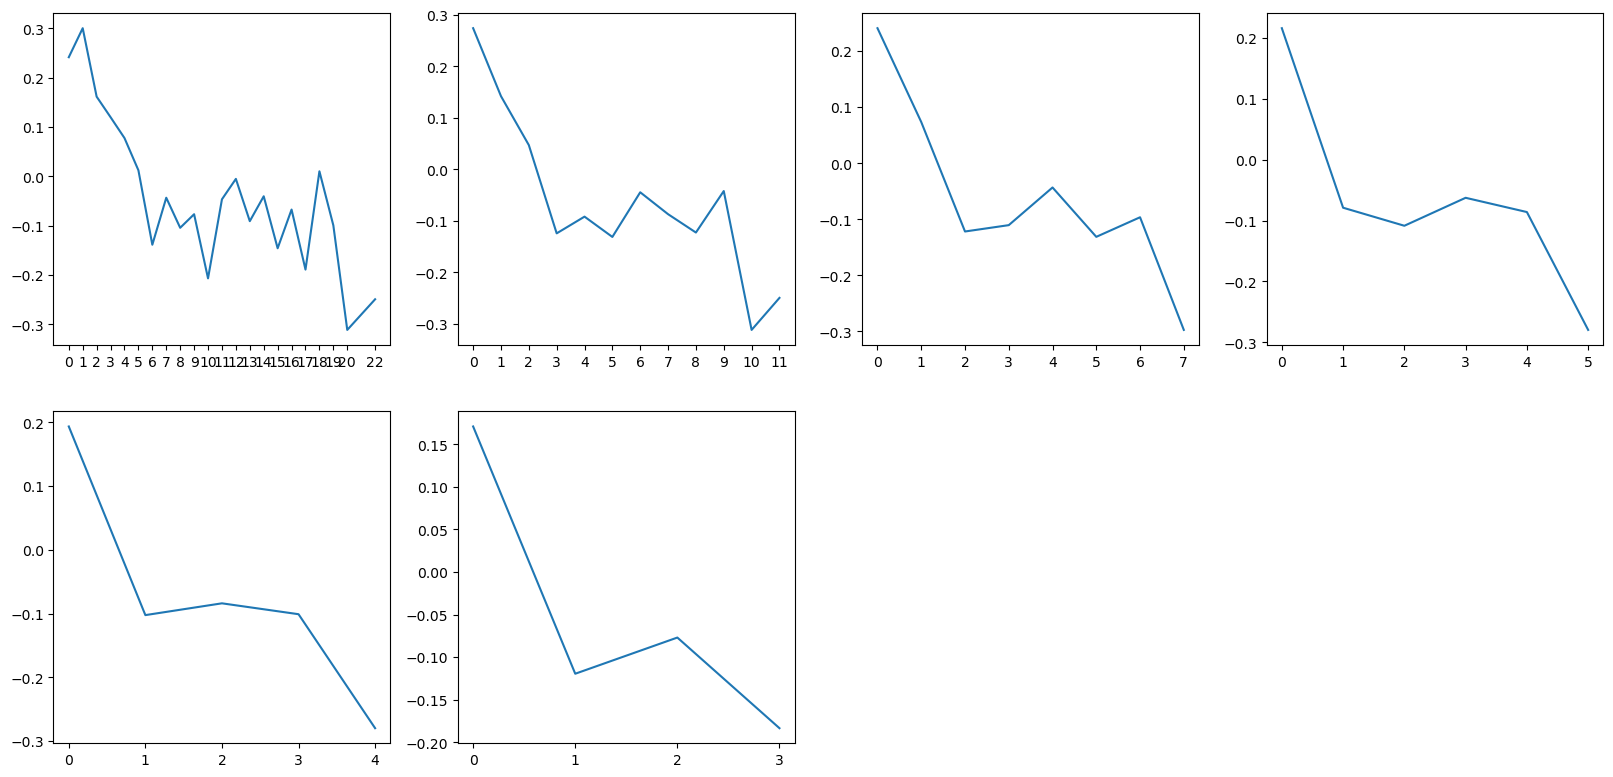

In [119]:
i = 0
fig = plt.figure(figsize=(20, 25))
for b in buckets_med:
    size = b[0]
    d = b[1]
    i += 1
    plt.subplot(5, 4, i)
    med = data['mths_since_recent_inq'].median()
    test['mths_since_recent_inq'] = data['mths_since_recent_inq'].fillna(med).map(lambda x: int(x) // size).map(d)
    res, woe, iv = WOE(test, 'mths_since_recent_inq', 'def')
    r = res.sort_values(by='mths_since_recent_inq')
    x = list(r.index)
    y = r['WOE']
    plt.plot(x, y)
    plt.xticks(x);

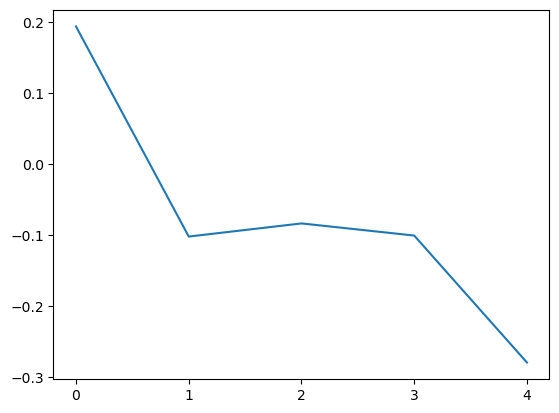

In [120]:
size_mths_since_recent_inq = buckets_med[4][0]
d_mths_since_recent_inq = buckets_med[4][1]
med_mths_since_recent_inq = data['mths_since_recent_inq'].median()

test['mths_since_recent_inq'] = data['mths_since_recent_inq'].fillna(med_mths_since_recent_inq).map(lambda x: int(x) // size_mths_since_recent_inq).map(d_mths_since_recent_inq)
res, woe, iv = WOE(test, 'mths_since_recent_inq', 'def')
r = res.sort_values(by='mths_since_recent_inq')
x = list(r.index)
y = r['WOE']
plt.plot(x, y)
plt.xticks(x);

In [121]:
final_buckets(buckets_med[4], data['mths_since_recent_inq'])

0-5, 5-10, 10-15, 15-20, 20-24.0


In [122]:
woe_mths_since_recent_inq = dict(woe)

def mths_since_recent_inq_processing(df):
    max_value = data['mths_since_recent_inq'].max()
    values = list(data['mths_since_recent_inq'].fillna(med_mths_since_recent_inq).map(lambda x: min(int(x), max_value) // size_mths_since_recent_inq).unique())
    return df.fillna(med_mths_since_recent_inq).map(lambda x: closest(min(int(x), max_value) // size_mths_since_recent_inq, values)).map(d_mths_since_recent_inq).map(woe_mths_since_recent_inq)

In [123]:
data_processing['mths_since_recent_inq'] = mths_since_recent_inq_processing

## delinq_2yrs

In [124]:
data['delinq_2yrs'].isna().sum()

0

In [125]:
data['delinq_2yrs'].value_counts(dropna=False)

0     50997
1      6987
2      1981
3       657
4       259
5       140
6        60
7        33
8        16
9        11
10        7
11        4
13        4
18        3
14        3
12        3
15        2
16        1
29        1
Name: delinq_2yrs, dtype: int64

In [126]:
buckets = bucketing(data, 'delinq_2yrs', 1, 29, 1)
buckets

  0%|          | 0/29 [00:00<?, ?it/s]

[]

In [127]:
res, woe, iv = WOE(data, 'delinq_2yrs', 'def')
iv

0.002657627030317071

## chargeoff_within_12_mths

In [128]:
data['chargeoff_within_12_mths'].isna().sum()

0

In [129]:
data['chargeoff_within_12_mths'].value_counts(normalize=True)

0    0.994294
1    0.005019
2    0.000621
3    0.000065
Name: chargeoff_within_12_mths, dtype: float64

Так как в 99.5% случаев признак принимает одно и то же значение, будет иметь смысл его исключить.

## num_accts_ever_120_pd

In [130]:
data['num_accts_ever_120_pd'].isna().sum()

11941

In [131]:
data['num_accts_ever_120_pd'].value_counts(dropna=False)

0.0     39427
NaN     11941
1.0      5561
2.0      2099
3.0       898
4.0       518
5.0       291
6.0       197
7.0        99
8.0        45
9.0        37
10.0       24
11.0       14
12.0       10
14.0        4
13.0        1
20.0        1
15.0        1
29.0        1
Name: num_accts_ever_120_pd, dtype: int64

In [132]:
test['num_accts_ever_120_pd'] = data['num_accts_ever_120_pd'].fillna(0)
buckets = bucketing(test, 'num_accts_ever_120_pd', 1, 29, 1)
buckets

  0%|          | 0/29 [00:00<?, ?it/s]

[]

In [133]:
med = data['num_accts_ever_120_pd'].median()
test['num_accts_ever_120_pd'] = data['num_accts_ever_120_pd'].fillna(med)
buckets = bucketing(test, 'num_accts_ever_120_pd', 1, 29, 1)
buckets

  0%|          | 0/29 [00:00<?, ?it/s]

[]

In [134]:
res, woe, iv = WOE(data, 'num_accts_ever_120_pd', 'def')
iv

0.0029619567844419298

## num_tl_90g_dpd_24m

In [135]:
data['num_tl_90g_dpd_24m'].isna().sum()

11941

In [136]:
data['num_tl_90g_dpd_24m'].value_counts(dropna=False)

0.0     46585
NaN     11941
1.0      2015
2.0       434
3.0        87
4.0        52
5.0        16
6.0        15
8.0         6
10.0        4
15.0        3
14.0        2
7.0         2
11.0        2
13.0        1
9.0         1
18.0        1
12.0        1
20.0        1
Name: num_tl_90g_dpd_24m, dtype: int64

In [137]:
test['num_tl_90g_dpd_24m'] = data['num_tl_90g_dpd_24m'].fillna(0)
buckets = bucketing(test, 'num_tl_90g_dpd_24m', 1, 20, 1)
buckets

  0%|          | 0/20 [00:00<?, ?it/s]

[]

In [138]:
med = data['num_tl_90g_dpd_24m'].median()
test['num_tl_90g_dpd_24m'] = data['num_tl_90g_dpd_24m'].fillna(med)
buckets = bucketing(test, 'num_tl_90g_dpd_24m', 1, 20, 1)
buckets

  0%|          | 0/20 [00:00<?, ?it/s]

[]

In [139]:
res, woe, iv = WOE(data, 'num_tl_90g_dpd_24m', 'def')
iv

0.0016649229464915502

## acc_open_past_24mths

In [140]:
data['acc_open_past_24mths'].isna().sum()

7886

In [141]:
data['acc_open_past_24mths'].value_counts(dropna=False)

3.0     8829
2.0     8133
4.0     7990
NaN     7886
5.0     6470
1.0     5857
6.0     4718
7.0     3269
0.0     2689
8.0     2104
9.0     1299
10.0     751
11.0     455
12.0     273
13.0     172
14.0     115
15.0      56
16.0      39
17.0      25
18.0      14
19.0      11
20.0       6
21.0       4
23.0       1
33.0       1
28.0       1
22.0       1
Name: acc_open_past_24mths, dtype: int64

In [142]:
test['acc_open_past_24mths'] = data['acc_open_past_24mths'].fillna(0)
buckets_zero = bucketing(test, 'acc_open_past_24mths', 1, 30, 1)
len(buckets_zero)

  0%|          | 0/30 [00:00<?, ?it/s]

4

In [143]:
med = data['acc_open_past_24mths'].median()
test['acc_open_past_24mths'] = data['acc_open_past_24mths'].fillna(med)
buckets_med = bucketing(test, 'acc_open_past_24mths', 1, 30, 1)
len(buckets_med)

  0%|          | 0/30 [00:00<?, ?it/s]

4

Построим графики и для заполнения нулем и для заполнения медианой и выберем из них самый монотонный.

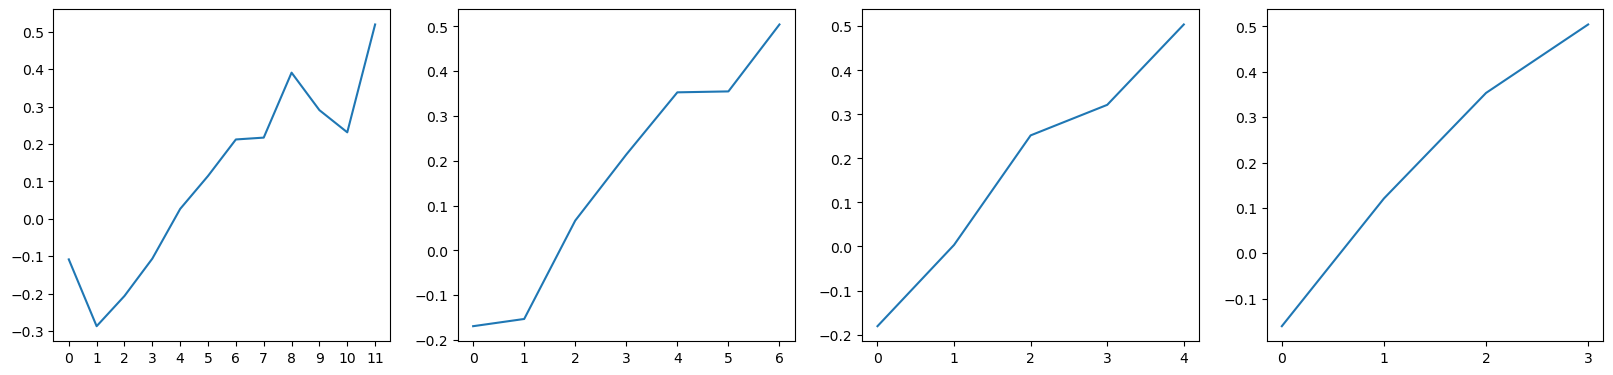

In [144]:
i = 0
fig = plt.figure(figsize=(20, 25))
for b in buckets_zero:
    size = b[0]
    d = b[1]
    i += 1
    plt.subplot(5, 4, i)
    test['acc_open_past_24mths'] = data['acc_open_past_24mths'].fillna(0).map(lambda x: int(x) // size).map(d)
    res, woe, iv = WOE(test, 'acc_open_past_24mths', 'def')
    r = res.sort_values(by='acc_open_past_24mths')
    x = list(r.index)
    y = r['WOE']
    plt.plot(x, y)
    plt.xticks(x);

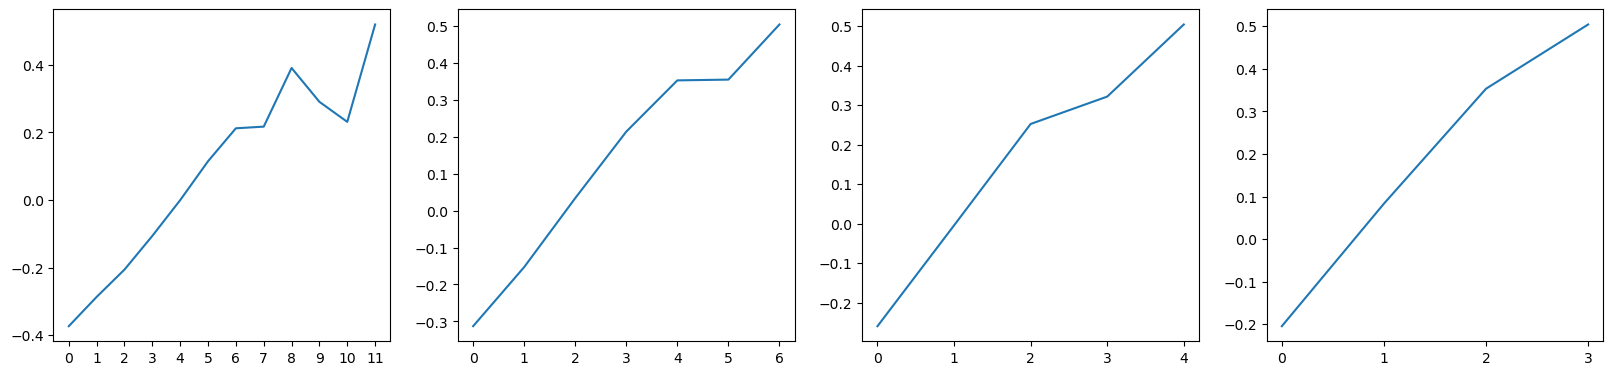

In [145]:
i = 0
fig = plt.figure(figsize=(20, 25))
for b in buckets_med:
    size = b[0]
    d = b[1]
    i += 1
    plt.subplot(5, 4, i)
    med = data['acc_open_past_24mths'].median()
    test['acc_open_past_24mths'] = data['acc_open_past_24mths'].fillna(med).map(lambda x: int(x) // size).map(d)
    res, woe, iv = WOE(test, 'acc_open_past_24mths', 'def')
    r = res.sort_values(by='acc_open_past_24mths')
    x = list(r.index)
    y = r['WOE']
    plt.plot(x, y)
    plt.xticks(x);

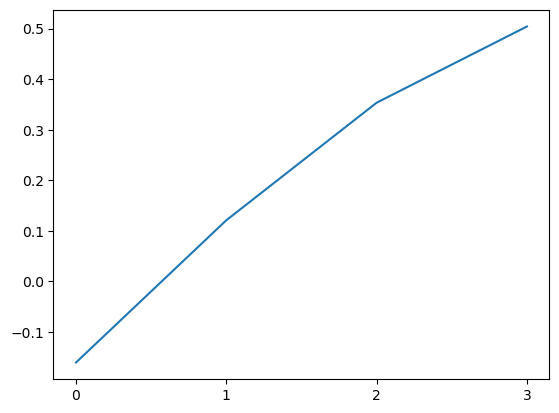

In [146]:
size_acc_open_past_24mths = buckets_zero[3][0]
d_acc_open_past_24mths = buckets_zero[3][1]

test['acc_open_past_24mths'] = data['acc_open_past_24mths'].fillna(0).map(lambda x: int(x) // size_acc_open_past_24mths).map(d_acc_open_past_24mths)
res, woe, iv = WOE(test, 'acc_open_past_24mths', 'def')
r = res.sort_values(by='acc_open_past_24mths')
x = list(r.index)
y = r['WOE']
plt.plot(x, y)
plt.xticks(x);


In [147]:
final_buckets(buckets_zero[3], data['acc_open_past_24mths'])

0-4, 4-8, 8-12, 12-33.0


In [148]:
woe_acc_open_past_24mths = dict(woe)

def acc_open_past_24mths_processing(df):
    max_value = data['acc_open_past_24mths'].max()
    values = list(data['acc_open_past_24mths'].fillna(0).map(lambda x: min(int(x), max_value) // size_acc_open_past_24mths).unique())
    return df.fillna(0).map(lambda x: closest(min(int(x), max_value) // size_acc_open_past_24mths, values)).map(d_acc_open_past_24mths).map(woe_acc_open_past_24mths)

In [149]:
data_processing['acc_open_past_24mths'] = acc_open_past_24mths_processing

## avg_cur_bal

In [150]:
data['avg_cur_bal'].isna().sum()

11945

In [151]:
data['avg_cur_bal'].describe()

count     49224.000000
mean      13734.641049
std       16054.221586
min           0.000000
25%        3025.000000
50%        7847.000000
75%       19527.000000
max      354015.000000
Name: avg_cur_bal, dtype: float64

In [152]:
test['avg_cur_bal'] = data['avg_cur_bal'].fillna(0)
buckets_zero = bucketing(test, 'avg_cur_bal', 10000, 354000, 5000)
len(buckets_zero)

  0%|          | 0/70 [00:00<?, ?it/s]

3

In [153]:
med = data['avg_cur_bal'].median()
test['avg_cur_bal'] = data['avg_cur_bal'].fillna(med)
buckets_med = bucketing(test, 'avg_cur_bal', 10000, 354000, 5000)
len(buckets_med)

  0%|          | 0/70 [00:00<?, ?it/s]

3

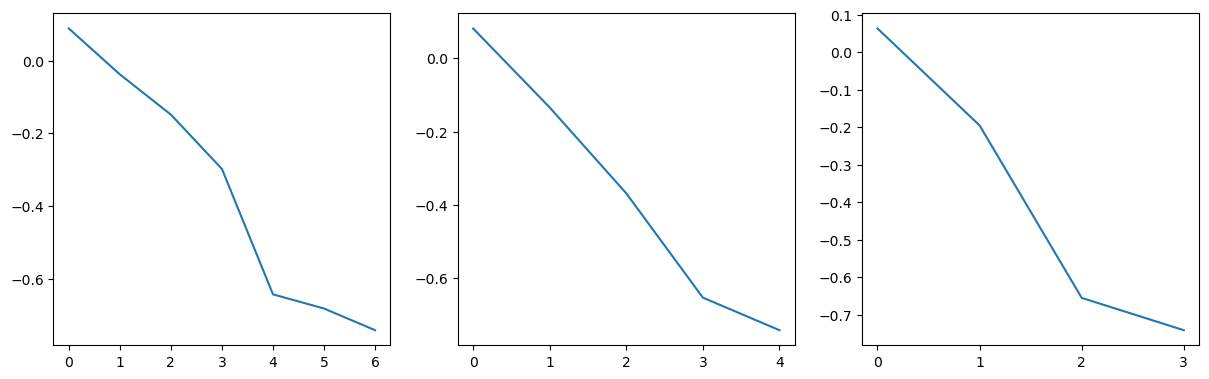

In [154]:
i = 0
fig = plt.figure(figsize=(20, 25))
for b in buckets_zero:
    size = b[0]
    d = b[1]
    i += 1
    plt.subplot(5, 4, i)
    test['avg_cur_bal'] = data['avg_cur_bal'].fillna(0).map(lambda x: int(x) // size).map(d)
    res, woe, iv = WOE(test, 'avg_cur_bal', 'def')
    r = res.sort_values(by='avg_cur_bal')
    x = list(r.index)
    y = r['WOE']
    plt.plot(x, y)
    plt.xticks(x);

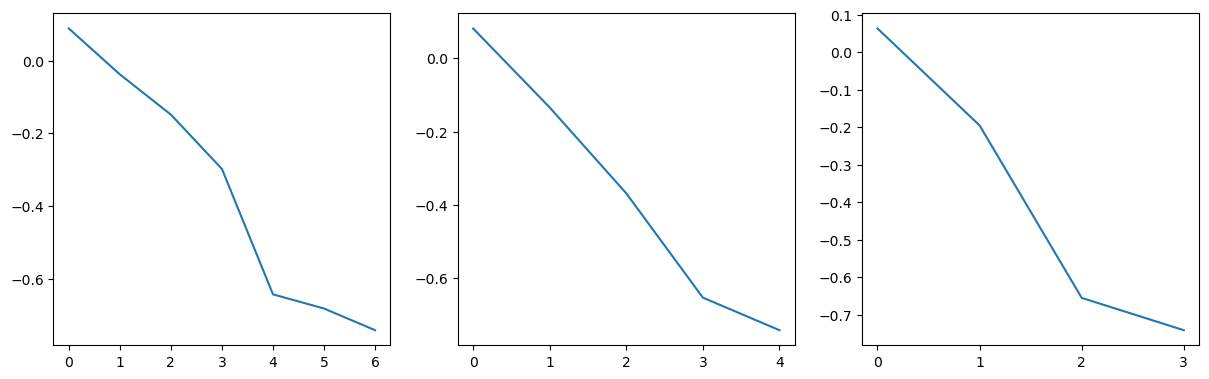

In [155]:
i = 0
fig = plt.figure(figsize=(20, 25))
for b in buckets_med:
    size = b[0]
    d = b[1]
    i += 1
    plt.subplot(5, 4, i)
    med = data['avg_cur_bal'].median()
    test['avg_cur_bal'] = data['avg_cur_bal'].fillna(med).map(lambda x: int(x) // size).map(d)
    res, woe, iv = WOE(test, 'avg_cur_bal', 'def')
    r = res.sort_values(by='avg_cur_bal')
    x = list(r.index)
    y = r['WOE']
    plt.plot(x, y)
    plt.xticks(x);

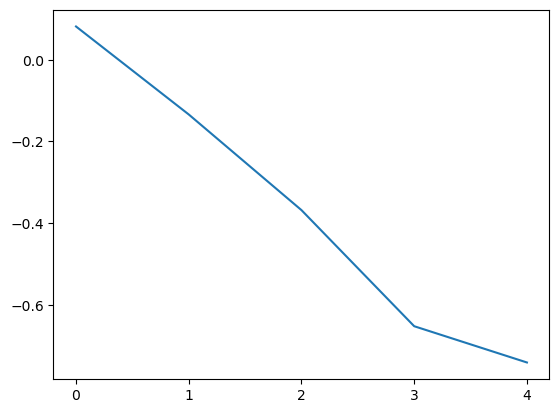

In [156]:
size_avg_cur_bal = buckets_zero[1][0]
d_avg_cur_bal = buckets_zero[1][1]

test['avg_cur_bal'] = data['avg_cur_bal'].fillna(0).map(lambda x: int(x) // size_avg_cur_bal).map(d_avg_cur_bal)
res, woe, iv = WOE(test, 'avg_cur_bal', 'def')
r = res.sort_values(by='avg_cur_bal')
x = list(r.index)
y = r['WOE']
plt.plot(x, y)
plt.xticks(x);

In [157]:
final_buckets(buckets_zero[1], data['avg_cur_bal'])

0-15000, 15000-30000, 30000-45000, 45000-60000, 60000-354015.0


In [158]:
woe_avg_cur_bal = dict(woe)

def avg_cur_bal_processing(df):
    max_value = data['avg_cur_bal'].max()
    values = list(data['avg_cur_bal'].fillna(0).map(lambda x: min(int(x), max_value) // size_avg_cur_bal).unique())
    return df.fillna(0).map(lambda x: closest(min(int(x), max_value) // size_avg_cur_bal, values)).map(d_avg_cur_bal).map(woe_avg_cur_bal)

In [159]:
data_processing['avg_cur_bal'] = avg_cur_bal_processing

## tot_hi_cred_lim

In [160]:
data['tot_hi_cred_lim'].isna().sum()

11941

In [161]:
data['tot_hi_cred_lim'].describe()

count    4.922800e+04
mean     1.671557e+05
std      1.699201e+05
min      0.000000e+00
25%      4.550000e+04
50%      1.110695e+05
75%      2.458785e+05
max      9.999999e+06
Name: tot_hi_cred_lim, dtype: float64

In [162]:
test['tot_hi_cred_lim'] = data['tot_hi_cred_lim'].fillna(0)
buckets_zero = bucketing(test, 'tot_hi_cred_lim', 100000, 10000000, 20000)
len(buckets_zero)

  0%|          | 0/496 [00:00<?, ?it/s]

4

In [163]:
med = data['tot_hi_cred_lim'].median()
test['tot_hi_cred_lim'] = data['tot_hi_cred_lim'].fillna(med)
buckets_med = bucketing(test, 'tot_hi_cred_lim', 100000, 10000000, 20000)
len(buckets_med)

  0%|          | 0/496 [00:00<?, ?it/s]

4

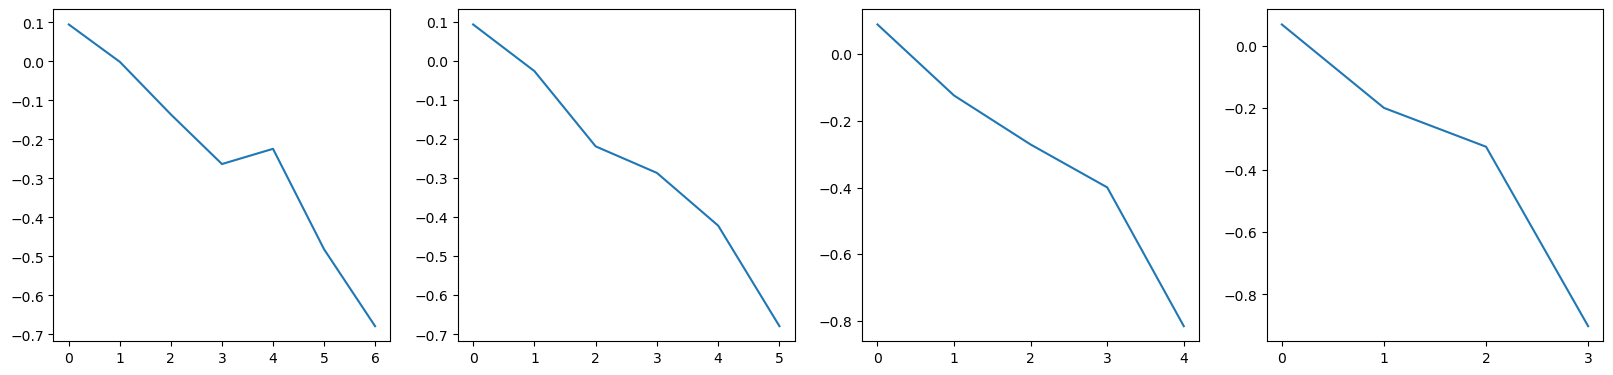

In [164]:
i = 0
fig = plt.figure(figsize=(20, 25))
for b in buckets_zero:
    size = b[0]
    d = b[1]
    i += 1
    plt.subplot(5, 4, i)
    test['tot_hi_cred_lim'] = data['tot_hi_cred_lim'].fillna(0).map(lambda x: int(x) // size).map(d)
    res, woe, iv = WOE(test, 'tot_hi_cred_lim', 'def')
    r = res.sort_values(by='tot_hi_cred_lim')
    x = list(r.index)
    y = r['WOE']
    plt.plot(x, y)
    plt.xticks(x);

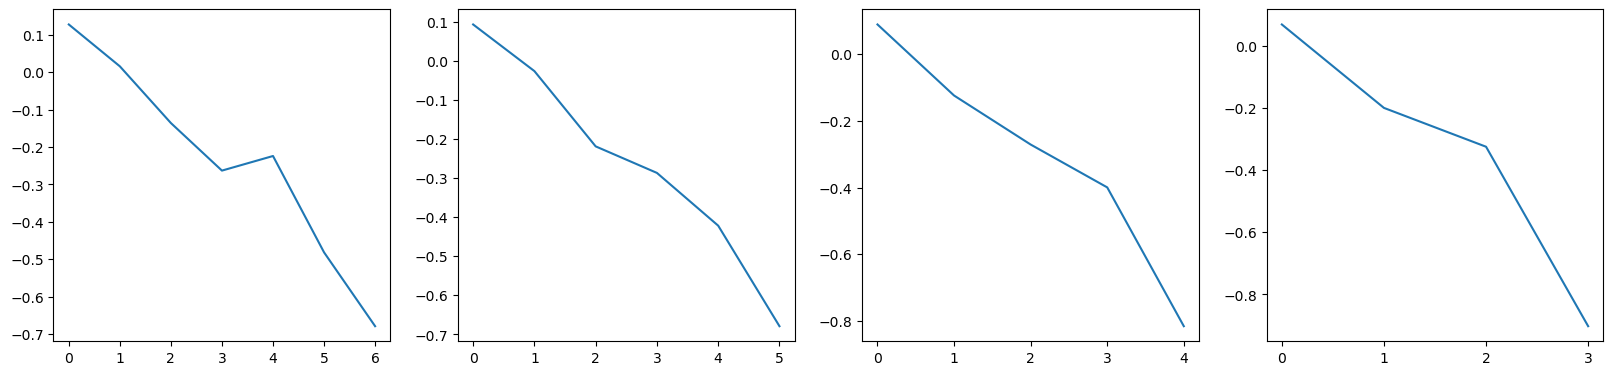

In [165]:
i = 0
fig = plt.figure(figsize=(20, 25))
for b in buckets_med:
    size = b[0]
    d = b[1]
    i += 1
    plt.subplot(5, 4, i)
    med = data['tot_hi_cred_lim'].median()
    test['tot_hi_cred_lim'] = data['tot_hi_cred_lim'].fillna(med).map(lambda x: int(x) // size).map(d)
    res, woe, iv = WOE(test, 'tot_hi_cred_lim', 'def')
    r = res.sort_values(by='tot_hi_cred_lim')
    x = list(r.index)
    y = r['WOE']
    plt.plot(x, y)
    plt.xticks(x);

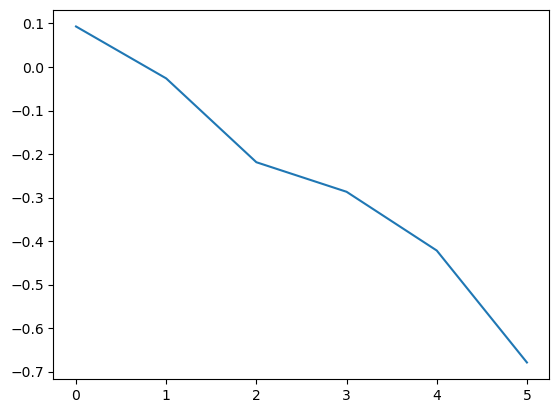

In [166]:
size_tot_hi_cred_lim = buckets_med[1][0]
d_tot_hi_cred_lim = buckets_med[1][1]
med_tot_hi_cred_lim = data['tot_hi_cred_lim'].median()

test['tot_hi_cred_lim'] = data['tot_hi_cred_lim'].fillna(med_tot_hi_cred_lim).map(lambda x: int(x) // size_tot_hi_cred_lim).map(d_tot_hi_cred_lim)
res, woe, iv = WOE(test, 'tot_hi_cred_lim', 'def')
r = res.sort_values(by='tot_hi_cred_lim')
x = list(r.index)
y = r['WOE']
plt.plot(x, y)
plt.xticks(x);

In [167]:
final_buckets(buckets_med[1], data['tot_hi_cred_lim'])

0-120000, 120000-240000, 240000-360000, 360000-480000, 480000-600000, 600000-9999999.0


In [168]:
woe_tot_hi_cred_lim = dict(woe)

def tot_hi_cred_lim_processing(df):
    max_value = data['tot_hi_cred_lim'].max()
    values = list(data['tot_hi_cred_lim'].fillna(med_tot_hi_cred_lim).map(lambda x: min(int(x), max_value) // size_tot_hi_cred_lim).unique())
    return df.fillna(med_tot_hi_cred_lim).map(lambda x: closest(min(int(x), max_value) // size_tot_hi_cred_lim, values)).map(d_tot_hi_cred_lim).map(woe_tot_hi_cred_lim)

In [169]:
data_processing['tot_hi_cred_lim'] = tot_hi_cred_lim_processing

## delinq_amnt

In [170]:
data['delinq_amnt'].isna().sum()

0

In [171]:
data['delinq_amnt'].value_counts(normalize=True)

0        0.997924
25       0.000098
30       0.000098
65000    0.000049
254      0.000033
           ...   
1420     0.000016
1921     0.000016
56       0.000016
94       0.000016
10       0.000016
Name: delinq_amnt, Length: 110, dtype: float64

Так как в 99.7% случаев признак принимает одно и то же значение, исключим его.

# Feature engineering

## funded_amnt / tot_hi_cred_lim

In [172]:
data[data['tot_hi_cred_lim'] == 0]

,issue_d,purpose,addr_state,sub_grade,home_ownership,emp_title,installment,dti,funded_amnt,annual_inc,...,mths_since_recent_inq,delinq_2yrs,chargeoff_within_12_mths,num_accts_ever_120_pd,num_tl_90g_dpd_24m,acc_open_past_24mths,avg_cur_bal,tot_hi_cred_lim,delinq_amnt,def
15001,2014-01-01,major_purchase,CA,C3,RENT,Creative Director,277.25,0.00,8000,120000.0,...,NaN,0,0,0.0,0.0,1.0,NaN,0.0,0,0
17146,2014-04-01,debt_consolidation,NJ,D4,OWN,Firefighter,647.42,0.00,25000,92800.0,...,7.0,0,0,0.0,0.0,0.0,NaN,0.0,0,1
20278,2013-01-01,car,OK,C4,RENT,Norman Police Department,105.91,0.00,3000,50000.0,...,NaN,0,0,0.0,0.0,0.0,NaN,0.0,0,0
23601,2013-11-01,vacation,CA,E2,RENT,Bookkeeper,115.29,24.27,4200,38500.0,...,8.0,0,0,2.0,0.0,0.0,NaN,0.0,0,0


In [173]:
data['tot_hi_cred_lim_2'] = data['tot_hi_cred_lim'].map(lambda x: data['tot_hi_cred_lim'].mean() if pd.isna(x) or x == 0 else x)

In [174]:
(data['funded_amnt'] / data['tot_hi_cred_lim_2'] * 100).isna().sum()

0

In [175]:
(data['funded_amnt'] / data['tot_hi_cred_lim_2'] * 100).describe()

count    61169.000000
mean        17.450394
std         25.112705
min          0.201284
25%          5.248289
50%          9.622302
75%         21.342895
max       2250.000000
dtype: float64

In [176]:
test['funded_amnt_tot_hi_cred_lim_2'] = data['funded_amnt'] / data['tot_hi_cred_lim_2'] * 100
buckets = bucketing(test, 'funded_amnt_tot_hi_cred_lim_2', 5, 2250, 5)

  0%|          | 0/450 [00:00<?, ?it/s]

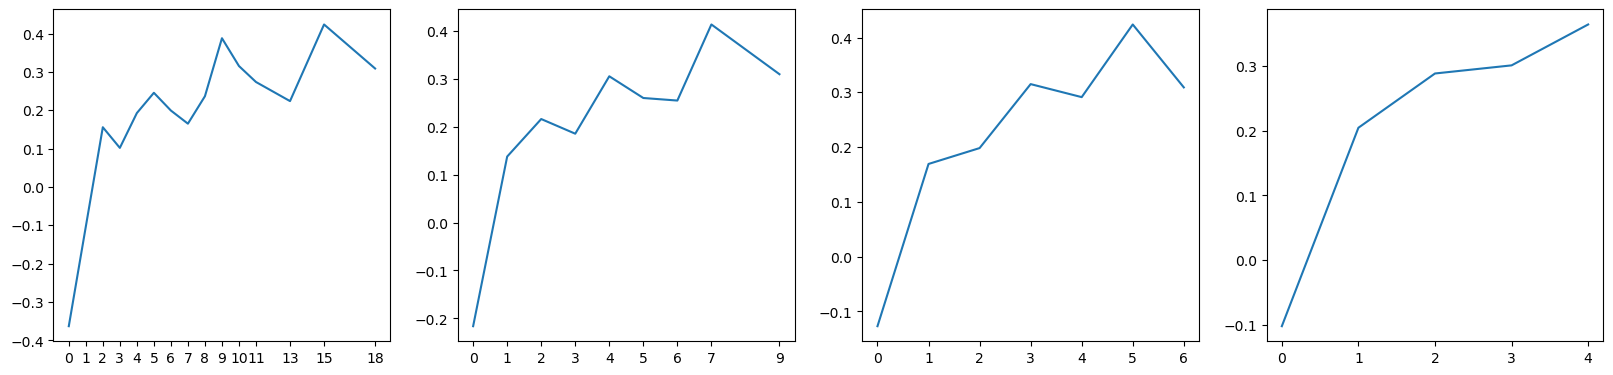

In [177]:
i = 0
fig = plt.figure(figsize=(20, 25))
for b in buckets:
    size = b[0]
    d = b[1]
    i += 1
    plt.subplot(5, 4, i)
    test['funded_amnt_tot_hi_cred_lim_2'] = (data['funded_amnt'] / data['tot_hi_cred_lim_2'] * 100).map(lambda x: int(x) // size).map(d)
    res, woe, iv = WOE(test, 'funded_amnt_tot_hi_cred_lim_2', 'def')
    r = res.sort_values(by='funded_amnt_tot_hi_cred_lim_2')
    x = list(r.index)
    y = r['WOE']
    plt.plot(x, y)
    plt.xticks(x);

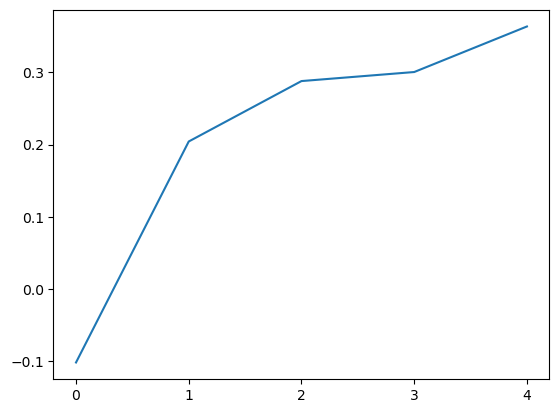

In [178]:
size_funded_amnt_tot_hi_cred_lim_2 = buckets[3][0]
d_funded_amnt_tot_hi_cred_lim_2 = buckets[3][1]

test['funded_amnt_tot_hi_cred_lim_2'] = (data['funded_amnt'] / data['tot_hi_cred_lim_2'] * 100).map(lambda x: int(x) // size_funded_amnt_tot_hi_cred_lim_2).map(d_funded_amnt_tot_hi_cred_lim_2)
res, woe, iv = WOE(test, 'funded_amnt_tot_hi_cred_lim_2', 'def')
r = res.sort_values(by='funded_amnt_tot_hi_cred_lim_2')
x = list(r.index)
y = r['WOE']
plt.plot(x, y)
plt.xticks(x);

In [179]:
final_buckets(buckets[3], test['funded_amnt_tot_hi_cred_lim_2'])

0-4, 4-20, 20-40, 40-60, 60-80


In [180]:
iv

0.025446396925967993

In [181]:
woe_funded_amnt_tot_hi_cred_lim_2 = dict(woe)

def funded_amnt_tot_hi_cred_lim_2_processing(df):
    max_value = data['funded_amnt_tot_hi_cred_lim_2'].max()
    values = list(data['funded_amnt_tot_hi_cred_lim_2'].map(lambda x: min(int(x), max_value) // size_funded_amnt_tot_hi_cred_lim_2).unique())
    return df.map(lambda x: closest(min(int(x), max_value) // size_funded_amnt_tot_hi_cred_lim_2, values)).map(d_funded_amnt_tot_hi_cred_lim_2).map(woe_funded_amnt_tot_hi_cred_lim_2)

In [182]:
data_processing['funded_amnt_tot_hi_cred_lim_2'] = funded_amnt_tot_hi_cred_lim_2_processing

## Финальное преобразование

In [183]:
X_train = pd.DataFrame()
data['tot_hi_cred_lim_2'] = data['tot_hi_cred_lim'].map(lambda x: data['tot_hi_cred_lim'].mean() if pd.isna(x) or x == 0 else x)
for column in data.columns:
    if column in data_processing:
        X_train[column] = data_processing[column](data[column])
for col1 in data.columns:
    for col2 in data.columns:
        if col1 + '_' + col2 in data_processing:
            data[col1 + '_' + col2] = data[col1] / data[col2] * 100
            X_train[col1 + '_' + col2] = data_processing[col1 + '_' + col2](data[col1 + '_' + col2])
y_train = data['def']

Cнова проверим корреляцию между признаками:

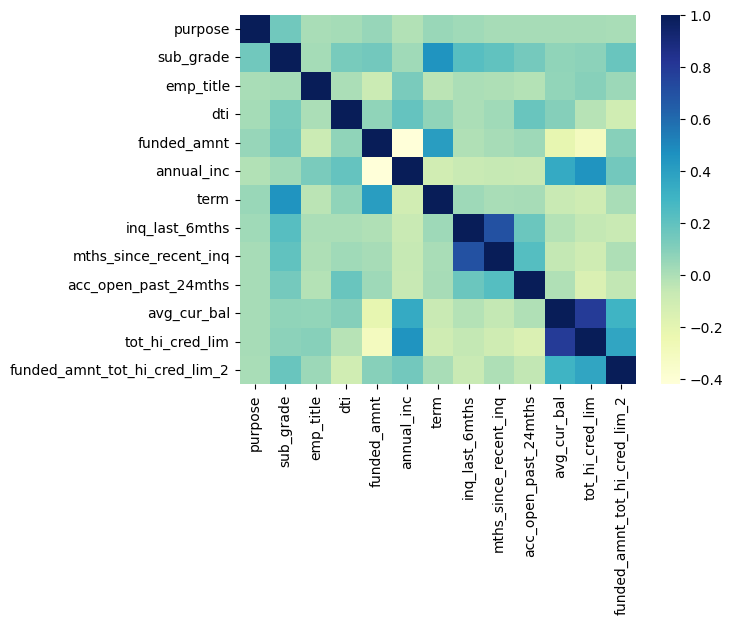

In [184]:
sns.heatmap(X_train.corr(), cmap="YlGnBu");

Вернемся к парам скоррелированных признаков, обсуждавшихся в самом начале, и оставим из каждой пары более информативный с точки зрения IV.

In [185]:
pairs = [['tot_hi_cred_lim', 'avg_cur_bal'], ['inq_last_6mths', 'mths_since_recent_inq']]

In [186]:
iv_s = {}
X_iv = X_train.copy()
X_iv['def'] = y_train
for feature in X_train.columns:
    iv_s[feature] = WOE(X_iv, feature, 'def')[2]

In [187]:
to_drop = set()
for a, b in pairs:
    if iv_s[a] < iv_s[b]:
        to_drop.add(a)
    elif iv_s[a] > iv_s[b]:
        to_drop.add(b)
    else:
        print('Error')

In [188]:
to_drop

{'mths_since_recent_inq', 'tot_hi_cred_lim'}

In [189]:
to_drop.add('term')
to_drop.add('funded_amnt')

In [190]:
sca = StandardScaler()
X_train = pd.DataFrame(data = sca.fit_transform(X_train.drop(columns=to_drop)), columns = X_train.drop(columns=to_drop).columns).sort_index(axis=1)

In [191]:
def to_dataset(data):
    X = pd.DataFrame()
    data['tot_hi_cred_lim_2'] = data['tot_hi_cred_lim'].map(lambda x: data['tot_hi_cred_lim'].mean() if pd.isna(x) or x == 0 else x)
    for column in data.columns:
        if column in data_processing:
            X[column] = data_processing[column](data[column])
    for col1 in data.columns:
        for col2 in data.columns:
            if col1 + '_' + col2 in data_processing:
                data[col1 + '_' + col2] = data[col1] / data[col2] * 100
                X[col1 + '_' + col2] = data_processing[col1 + '_' + col2](data[col1 + '_' + col2])
    y = data['def']
    return pd.DataFrame(data = sca.fit_transform(X.drop(columns=to_drop)), columns = X.drop(columns=to_drop).columns).sort_index(axis=1), y

# Logistic Regression

Подберем коэффицент регуляризации по валидационной выборке.

Нарисуем зависимость ROC-AUC модели на валидационной выборке в зависимости от значений гиперпараметра.

  0%|          | 0/200 [00:00<?, ?it/s]

Максимальный ROC-AUC на валидационной выборке: 0.664158842076152
Оптимальный коэффицент регуляризации C: 0.13


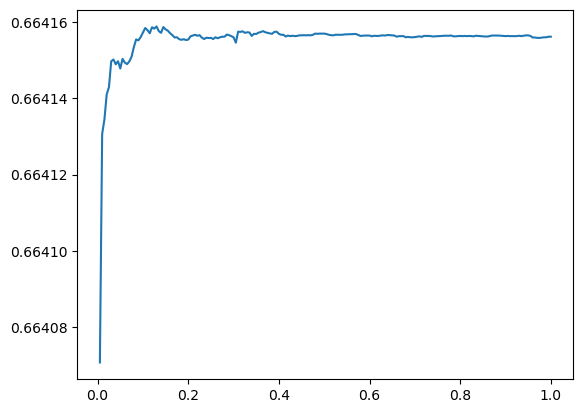

In [192]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train, y_train, test_size=0.2, random_state=3)
val_scores = []
max_score = -1
coef = -1
for i in tqdm(np.arange(0.005, 1.005, 0.005)):
    mod = LogisticRegression(penalty='l2', C=i)
    mod.fit(X_train1, y_train1)
    score = roc_auc_score(y_val1, mod.predict_proba(X_val1)[:, 1])
    val_scores.append(score)
    if score > max_score:
        max_score = score
        coef = i
plt.plot(np.arange(0.005, 1.005, 0.005), val_scores);
print(f'Максимальный ROC-AUC на валидационной выборке: {max_score}')
print(f'Оптимальный коэффицент регуляризации C: {coef}')

Обучим модель с подобранным гиперпараметром:

In [193]:
lr = LogisticRegression(penalty='l2', C=0.13)
lr.fit(X_train, y_train)

LogisticRegression(C=0.13)

# Validation

In [194]:
val = pd.read_csv('vl_for_students.csv')

val.head()

,issue_d,purpose,addr_state,sub_grade,home_ownership,emp_title,installment,dti,funded_amnt,annual_inc,...,mths_since_recent_inq,delinq_2yrs,chargeoff_within_12_mths,num_accts_ever_120_pd,num_tl_90g_dpd_24m,acc_open_past_24mths,avg_cur_bal,tot_hi_cred_lim,delinq_amnt,def
0,2015-04-01,debt_consolidation,CT,C5,MORTGAGE,Director,689.89,17.22,20000,270000.0,...,0.0,1,0,0,0,8,47255,820469.0,0,0
1,2014-09-01,debt_consolidation,WI,D1,MORTGAGE,Underwriting Manager,578.68,25.10,24000,84000.0,...,NaN,0,0,0,0,2,17604,271531.0,0,1
2,2014-10-01,debt_consolidation,AZ,D3,OWN,Haul Truck Operator,534.72,17.97,15000,59028.0,...,4.0,1,0,3,0,8,3697,56655.0,0,0
3,2014-07-01,debt_consolidation,FL,C2,MORTGAGE,Duct mechanic,203.18,15.82,6000,46280.0,...,2.0,0,0,2,0,3,5875,41036.0,0,0
4,2015-01-01,credit_card,CA,B5,OWN,Engineer,1162.34,14.37,35000,150000.0,...,NaN,2,1,2,2,2,55056,576535.0,0,0


In [195]:
X_val, y_val = to_dataset(val)

## Тест M2.1: Эффективность ранжирования всей модели

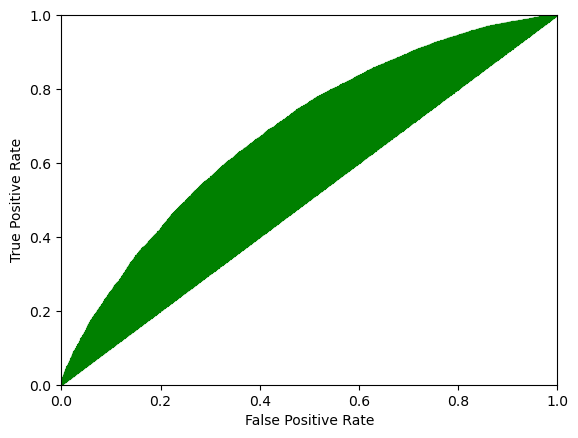

In [196]:
fpr, tpr, thresholds = roc_curve(y_val, lr.predict_proba(X_val)[:, 1])
plt.plot(fpr, tpr, color='green')
plt.plot(np.arange(0, 1.05, 0.05), np.arange(0, 1.05, 0.05), color='green')
for i in range(len(fpr)):
    if i % 20 == 0:
        plt.plot([fpr[i], fpr[i]], [fpr[i], tpr[i]], color='green')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [197]:
print(f'Коэффицент Джини: {2 * roc_auc_score(y_val, lr.predict_proba(X_val)[:, 1]) - 1}')

Коэффицент Джини: 0.36827567053686283


## Тест M2.2: Эффективность ранжирования отдельных факторов

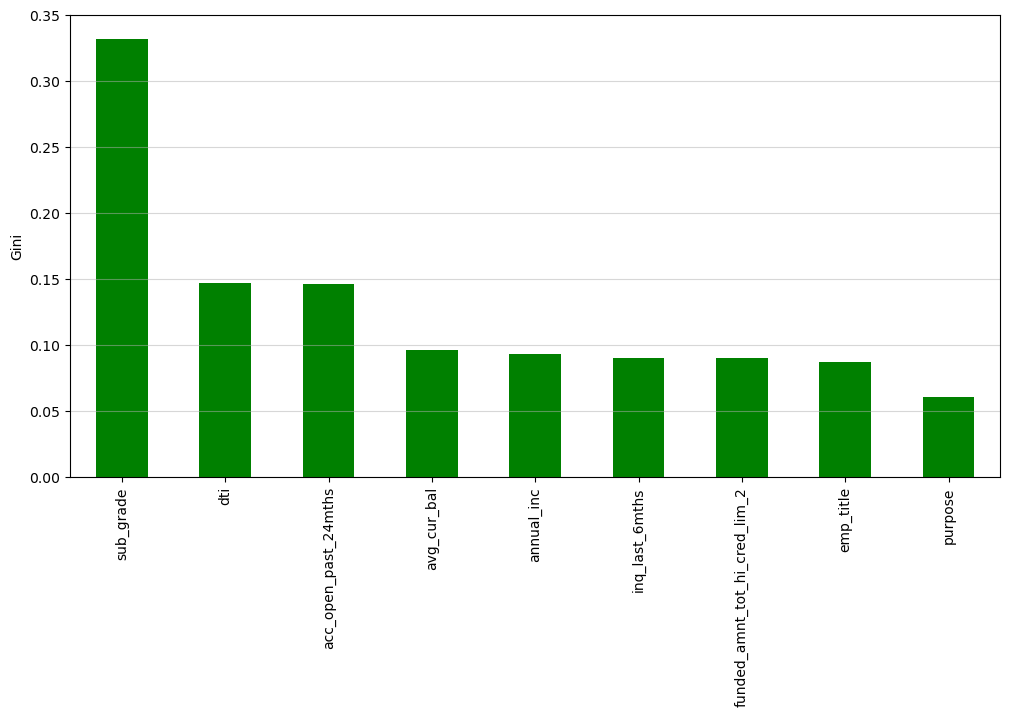

In [198]:
gini_for_features = {}
for column in X_val.columns:
    X_zeros = pd.DataFrame(np.zeros(X_val.shape), columns=X_val.columns)
    X_zeros[column] = X_val[column]
    gini_for_features[column] = 2 * roc_auc_score(y_val, lr.predict_proba(X_zeros)[:, 1]) - 1

plt.figure(figsize=(12, 6))
pd.Series(gini_for_features).sort_values(ascending=False).plot(kind='bar', color='green')
plt.ylim([0.0, 0.35])
plt.ylabel('Gini')
plt.grid(axis='y', alpha=0.5);

## Тест M2.5: Анализ вкладов факторов в формирование Джини модели

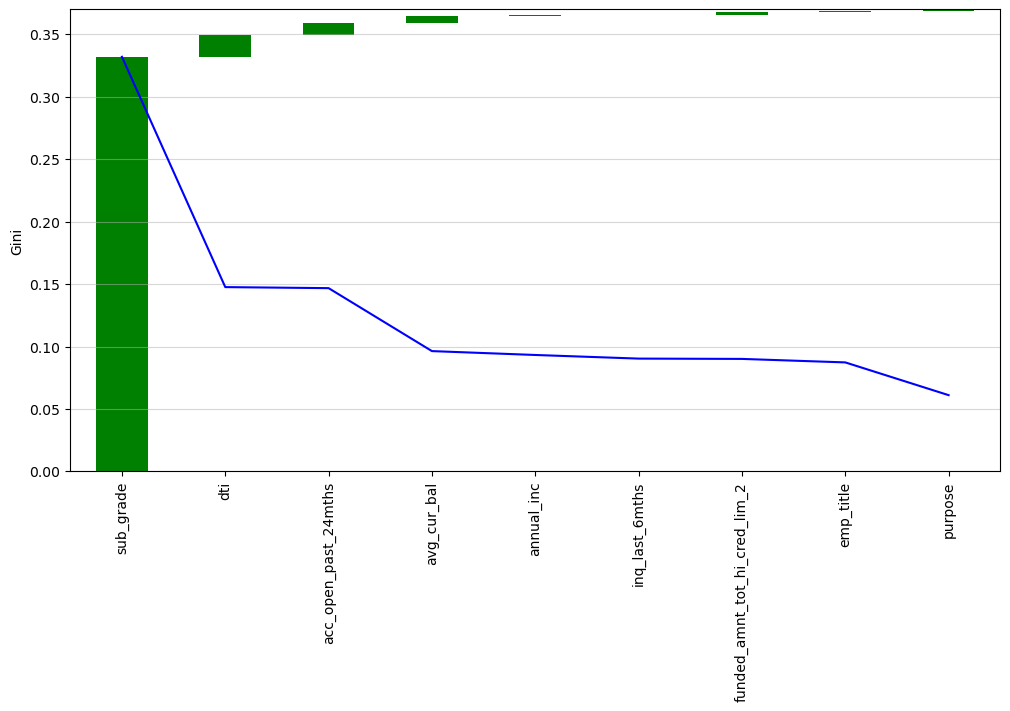

In [199]:
gini_uplifts = {}
X_zeros = pd.DataFrame(np.zeros(X_val.shape), columns=X_val.columns)
columns_sorted = list(pd.Series(gini_for_features).sort_values(ascending=False).index)
for column in columns_sorted:
    X_zeros[column] = X_val[column]
    gini_uplifts[column] = 2 * roc_auc_score(y_val, lr.predict_proba(X_zeros)[:, 1]) - 1
    
plt.figure(figsize=(12, 6))
pd.Series(gini_uplifts).sort_values().plot(kind='bar', color='green')
pd.Series([0] + list(pd.Series(gini_uplifts).sort_values())[:-1]).sort_values().plot(kind='bar', color='white')
pd.Series(gini_for_features).sort_values(ascending=False).plot(kind='line', color='blue')
plt.ylim([0.0, 0.37])
plt.ylabel('Gini')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.5);

## Тест M2.4: Динамика коэффициента Джини

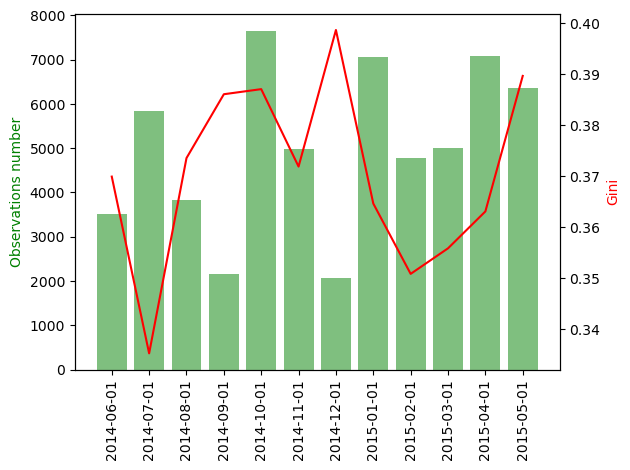

In [200]:
gini_monthly = {}
obs_number = {}
dates = sorted(val['issue_d'].unique())
for date in dates:
    X_monthly, y_monthly = to_dataset(val[val['issue_d'] == date])
    gini_monthly[date] = 2 * roc_auc_score(y_monthly, lr.predict_proba(X_monthly)[:, 1]) - 1
    obs_number[date] = X_monthly.shape[0]

fig, ax1 = plt.subplots()
ax1.set_ylabel('Observations number', color='green')
ax1.bar(x=list(pd.Series(obs_number).sort_index().index), height=list(pd.Series(obs_number).sort_index().values), alpha=0.5, color='green')
plt.xticks(rotation=90)
ax2 = ax1.twinx()
ax2.set_ylabel('Gini', color='red')
ax2.plot(pd.Series(gini_monthly).sort_index(), color='red')
fig.tight_layout();

## Тест M4.1: Сравнение прогнозного и фактического TR (Target Rate) на уровне выборки

In [201]:
print(f'Среднее арифметическое значение вероятности наступления целевого события: {lr.predict_proba(X_val)[:, 1].mean()}')

Среднее арифметическое значение вероятности наступления целевого события: 0.1614381049493969


In [202]:
print(f'Средний уровень целевого события: {y_val.mean()}')

Средний уровень целевого события: 0.1767357830706247


In [203]:
abs(y_val.mean() - lr.predict_proba(X_val)[:, 1].mean()) / y_val.mean()

0.08655676770965373

## Тест M4.2: Тест формы калибровочной кривой

In [204]:
cal_curve_pre = pd.DataFrame()
cal_curve_pre['probas'] = lr.predict_proba(X_val)[:, 1]
cal_curve_pre['true'] = y_val
cal_curve_pre = cal_curve_pre.sort_values(by='probas')
cal_curve_pre['ind'] = np.arange(0, cal_curve_pre.shape[0])
cal_curve_pre['bucket'] = cal_curve_pre['ind'] // 6000
cal_curve = cal_curve_pre.groupby('bucket', as_index=False).agg({'probas' : 'mean', 'true' : 'mean'})
cal_curve['metric'] = abs(cal_curve['true'] - cal_curve['probas']) / cal_curve['true']

In [205]:
cal_curve

,bucket,probas,true,metric
0,0,0.042412,0.046333,0.084634
1,1,0.064584,0.075167,0.140789
2,2,0.088561,0.101500,0.127474
3,3,0.111746,0.124500,0.102440
4,4,0.135141,0.147833,0.085858
5,5,0.162011,0.174333,0.070682
6,6,0.189736,0.205333,0.075963
7,7,0.218666,0.239500,0.086988
8,8,0.256919,0.284667,0.097475
9,9,0.328474,0.350333,0.062397


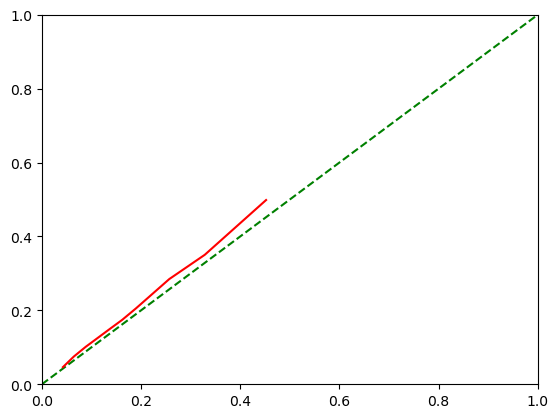

In [206]:
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.plot(cal_curve['probas'], cal_curve['true'], color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0]);

In [207]:
cal_curve

,bucket,probas,true,metric
0,0,0.042412,0.046333,0.084634
1,1,0.064584,0.075167,0.140789
2,2,0.088561,0.101500,0.127474
3,3,0.111746,0.124500,0.102440
4,4,0.135141,0.147833,0.085858
5,5,0.162011,0.174333,0.070682
6,6,0.189736,0.205333,0.075963
7,7,0.218666,0.239500,0.086988
8,8,0.256919,0.284667,0.097475
9,9,0.328474,0.350333,0.062397


In [208]:
print(f'Доля точек с метрикой >20%: {cal_curve[cal_curve["metric"] > 0.2].shape[0] / cal_curve.shape[0]}')

Доля точек с метрикой >20%: 0.0


## Тест M5.1: Сравнение эффективности ранжирования модели на разработке и валидации

In [209]:
print(f'Абсолютное изменение коэффициента Джини при валидации по сравнению с этапом разработки модели: {(2 * roc_auc_score(y_val, lr.predict_proba(X_val)[:, 1]) - 1) - (2 * roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1]) - 1)}')

Абсолютное изменение коэффициента Джини при валидации по сравнению с этапом разработки модели: 0.010656006545780139


In [210]:
print(f'Относительное изменение коэффициента Джини при валидации по сравнению с этапом разработки модели: {((2 * roc_auc_score(y_val, lr.predict_proba(X_val)[:, 1]) - 1) - (2 * roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1]) - 1)) / (2 * roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1]) - 1)}')

Относительное изменение коэффициента Джини при валидации по сравнению с этапом разработки модели: 0.029797037519854748


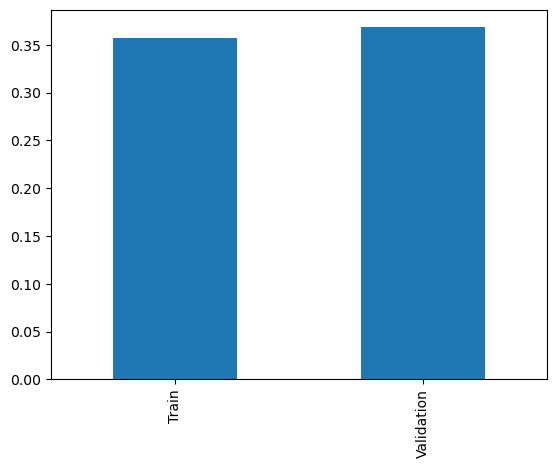

In [211]:
ginis_comparison = {'Train': 2 * roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1]) - 1, 'Validation': 2 * roc_auc_score(y_val, lr.predict_proba(X_val)[:, 1]) - 1}
pd.Series(ginis_comparison).plot(kind='bar');

## Тест M5.2: Сравнение эффективности ранжирования отдельных факторов модели на разработке и валидации

In [212]:
def feature_flg(x):
    if x['abs_change'] < -0.05 and x['rel_change'] < -0.2:
        return 'red'
    elif x['abs_change'] < -0.03 and x['rel_change'] < -0.15:
        return 'yellow'
    else:
        return 'green'

In [213]:
gini_for_features_train = {}
gini_for_features_val = {}
for column in X_val.columns:
    X_zeros = pd.DataFrame(np.zeros(X_train.shape), columns=X_train.columns)
    X_zeros[column] = X_train[column]
    gini_for_features_train[column] = 2 * roc_auc_score(y_train, lr.predict_proba(X_zeros)[:, 1]) - 1
    X_zeros = pd.DataFrame(np.zeros(X_val.shape), columns=X_val.columns)
    X_zeros[column] = X_val[column]
    gini_for_features_val[column] = 2 * roc_auc_score(y_val, lr.predict_proba(X_zeros)[:, 1]) - 1

In [214]:
gini_features_comp = pd.DataFrame()
gini_features_comp['gini_train'] = gini_for_features_train
gini_features_comp['gini_val'] = gini_for_features_val
gini_features_comp['abs_change'] = gini_features_comp['gini_val'] - gini_features_comp['gini_train']
gini_features_comp['rel_change'] = (gini_features_comp['gini_val'] - gini_features_comp['gini_train']) / gini_features_comp['gini_train']
gini_features_comp['feature_flg'] = gini_features_comp.apply(lambda x: feature_flg(x), axis=1)

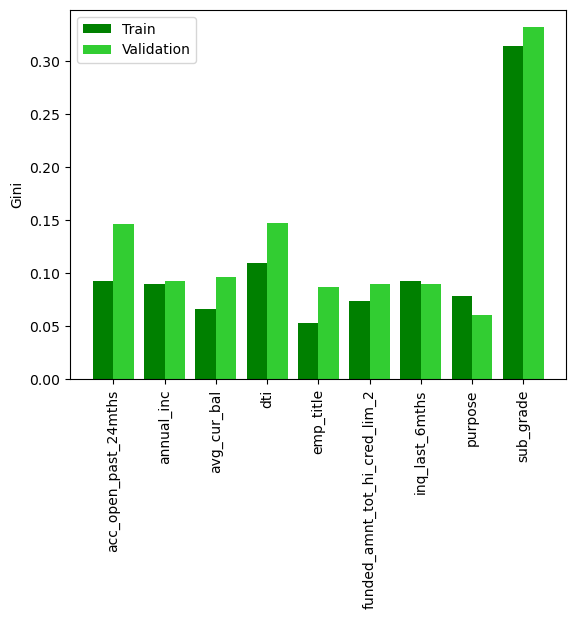

In [215]:
plt.bar(gini_features_comp.index, gini_features_comp['gini_train'], width=-0.4, align='edge', label='Train', color='green')
plt.bar(gini_features_comp.index, gini_features_comp['gini_val'], width=0.4, align='edge', label='Validation', color='limegreen')
plt.xticks(rotation=90)
plt.ylabel('Gini')
plt.legend();

In [216]:
gini_features_comp

,gini_train,gini_val,abs_change,rel_change,feature_flg
acc_open_past_24mths,0.092746,0.146763,0.054017,0.582416,green
annual_inc,0.090019,0.093239,0.003220,0.035772,green
avg_cur_bal,0.066240,0.096341,0.030101,0.454420,green
dti,0.109655,0.147593,0.037938,0.345981,green
emp_title,0.053139,0.087293,0.034154,0.642733,green
funded_amnt_tot_hi_cred_lim_2,0.073670,0.090090,0.016420,0.222891,green
inq_last_6mths,0.092526,0.090339,-0.002187,-0.023638,green
purpose,0.078703,0.061069,-0.017634,-0.224061,green
sub_grade,0.314731,0.332032,0.017300,0.054968,green


# Скоринговая карта

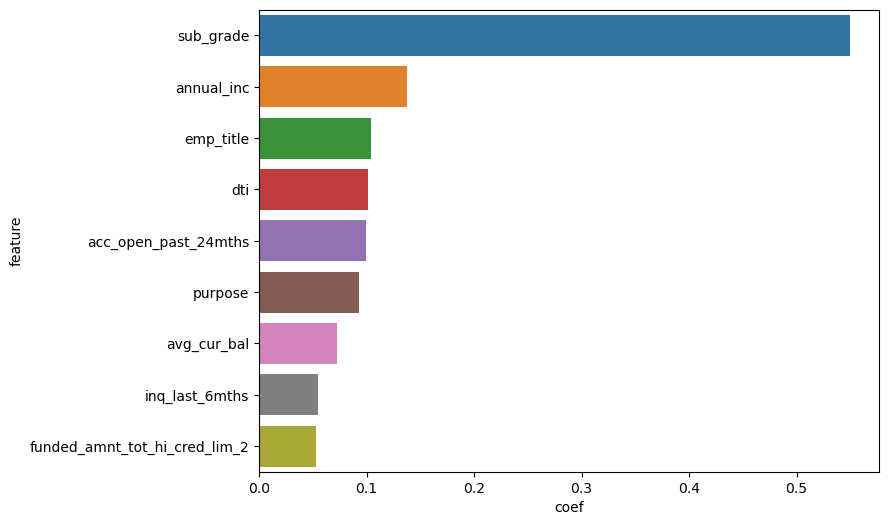

In [217]:
feature_importances = pd.DataFrame(lr.coef_[0].reshape((-1, 1)), pd.Series(X_train.columns)).reset_index()
feature_importances.columns = ['feature', 'coef']
feature_importances['abs_coef'] = feature_importances['coef'].map(lambda x: abs(x))
fig = plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importances.sort_values(by='abs_coef', ascending=False), x='coef', y='feature');

По значениям коэффицентов регрессии при признаках мы можем увидеть, какие из них вносят самый большой вклад в решение о выдаче кредита.

# Расчет ожидаемой прибыли от кредитования

Прибыль для каждого кредита рассчитывается по формуле installment * term - funded_amnt.

Если банк решает выдать кредит и клиент возвращает кредит, банк получает прибыль в размере installment * term - funded_amnt, если клиент не возвращает -- убытки в размере funded_amnt.

Если банк решает не выдавать кредит, его прибыль равна 0.

Таким образом, ожидаемая прибыль банка от кредитования -- сумма по всем клиентам, которым решили выдать кредит, выражения (1 - вер-ть дефолта) * (installment * term - funded_amnt) - вер-ть дефолта * funded_amnt.

Задача заключается в нахождении оптимального правила для решения о выдаче кредита с целью максимизации ожидаемой прибыли от кредитования. Оптимальным правилом является порог предсказанной вероятности дефолта, выше которого банк отказывается выдавать кредит клиенту.

## Случай 1: в случае дефолта теряем весь кредит

In [218]:
profit_train = []

profit_df = pd.DataFrame()
profit_df['return_credit'] = 1 - data['def']
profit_df['funded_amnt'] = data['funded_amnt']
profit_df['credit_revenue'] = data['installment'] * data['term']
for threshold in np.arange(0, 1.01, 0.01):
    profit_df['give_credit'] = 1 - pd.Series(lr.predict_proba(X_train)[:, 1] > threshold).astype(int)
    profit = profit_df['give_credit'] * profit_df['return_credit'] * (profit_df['credit_revenue'] - profit_df['funded_amnt']) - profit_df['give_credit'] * (1 - profit_df['return_credit']) * profit_df['funded_amnt']
    profit_train.append(profit.sum())
    
profit_val = []

profit_df = pd.DataFrame()
profit_df['return_credit'] = 1 - val['def']
profit_df['funded_amnt'] = val['funded_amnt']
profit_df['credit_revenue'] = val['installment'] * val['term']
for threshold in np.arange(0, 1.01, 0.01):
    profit_df['give_credit'] = 1 - pd.Series(lr.predict_proba(X_train)[:, 1] > threshold).astype(int)
    profit = profit_df['give_credit'] * profit_df['return_credit'] * (profit_df['credit_revenue'] - profit_df['funded_amnt']) - profit_df['give_credit'] * (1 - profit_df['return_credit']) * profit_df['funded_amnt']
    profit_val.append(profit.sum())

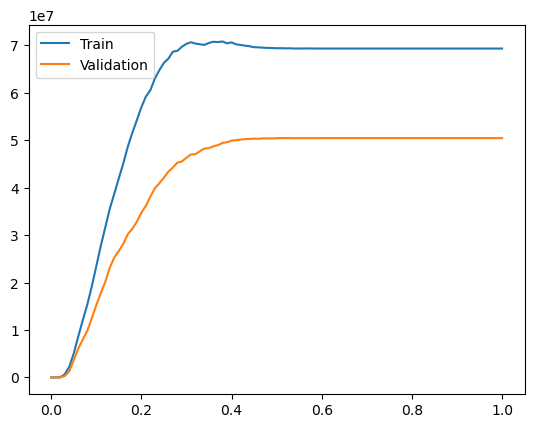

In [219]:
plt.plot(np.arange(0, 1.01, 0.01), profit_train, label='Train')
plt.plot(np.arange(0, 1.01, 0.01), profit_val, label='Validation')
plt.legend();

In [220]:
print(f'Оптимальный порог отсечения: {np.array(profit_train).argmax() * 0.01}')

Оптимальный порог отсечения: 0.38


In [221]:
print(f'Прибыль на валидационной выборке для оптимального порога отсечения: {profit_val[np.array(profit_train).argmax()]}')

Прибыль на валидационной выборке для оптимального порога отсечения: 49425537.16


## Случай 2: в случае дефолта теряем 80% кредита

In [222]:
profit_train = []

profit_df = pd.DataFrame()
profit_df['return_credit'] = 1 - data['def']
profit_df['funded_amnt'] = data['funded_amnt']
profit_df['credit_revenue'] = data['installment'] * data['term']
for threshold in np.arange(0, 1.01, 0.01):
    profit_df['give_credit'] = 1 - pd.Series(lr.predict_proba(X_train)[:, 1] > threshold).astype(int)
    profit = profit_df['give_credit'] * profit_df['return_credit'] * (profit_df['credit_revenue'] - profit_df['funded_amnt']) - 0.8 * profit_df['give_credit'] * (1 - profit_df['return_credit']) * profit_df['funded_amnt']
    profit_train.append(profit.sum())
    
profit_val = []

profit_df = pd.DataFrame()
profit_df['return_credit'] = 1 - val['def']
profit_df['funded_amnt'] = val['funded_amnt']
profit_df['credit_revenue'] = val['installment'] * val['term']
for threshold in np.arange(0, 1.01, 0.01):
    profit_df['give_credit'] = 1 - pd.Series(lr.predict_proba(X_train)[:, 1] > threshold).astype(int)
    profit = profit_df['give_credit'] * profit_df['return_credit'] * (profit_df['credit_revenue'] - profit_df['funded_amnt']) - 0.8 * profit_df['give_credit'] * (1 - profit_df['return_credit']) * profit_df['funded_amnt']
    profit_val.append(profit.sum())

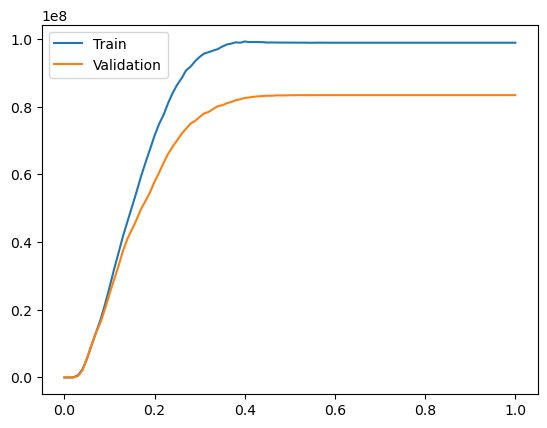

In [223]:
plt.plot(np.arange(0, 1.01, 0.01), profit_train, label='Train')
plt.plot(np.arange(0, 1.01, 0.01), profit_val, label='Validation')
plt.legend();

In [224]:
print(f'Оптимальный порог отсечения: {np.array(profit_train).argmax() * 0.01}')

Оптимальный порог отсечения: 0.4


In [225]:
print(f'Прибыль на валидационной выборке для оптимального порога отсечения: {profit_val[np.array(profit_train).argmax()]}')

Прибыль на валидационной выборке для оптимального порога отсечения: 82553060.76000002
